# Flight Price Prediction #

## Introduction ##

Traveling by air is a common practice for many people around the globe, and the cost of air travel is a major factor in travel planning. For a given route, airfares can fluctuate significantly over time due to a variety of factors, such as demand, seasonality, and airline pricing strategies. This can lead to a common predicament for travelers: should they purchase their tickets now, or wait in the hopes of a price drop?

The aim of this project is to build a machine learning model that can help resolve this predicament. The model will predict whether it is optimal to purchase the ticket now or wait for a potential price drop.

The dataset used in this notebook is provided by Prof. Dr. Martin Spott and Manu Mutthatu.
It contains flight data from 2019 for the following routes:
-   London Stansted and Berlin Schönefeld
-   London Stansted and Frankfurt

This task is a practical application of machine learning that can provide valuable insights for both travelers and businesses in the travel industry. By predicting the optimal time to purchase a flight ticket, one can potentially save money and make travel planning less stressful. For businesses, this model can be used to build a buisness plan, to recommend the best time to purchase tickets to customers, or to optimize pricing strategies.


---



This notebook is organized as follows:
1. Load the data
2. Data Exploration and Feature Engineering
3. Prepare the Data for Model Training
4. Model Selection
5. Model Evaluation
6. Sources

## Load the data ##

In this section, we will load the necessary Python libraries and the dataset we will be working with. This dataset, stored in a CSV file, is seperated in a train and a test dataset, each containing information about flight price requests. The test dataset is used to finally evaluate the performance of the model we will train on the train dataset. So in this notebook we will mostly use the train dataset and only use the test dataset to create a final prediction based on the trained model.

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import math
import sklearn
import xgboost as xgb

from datetime import date
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from pandas.plotting import scatter_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from prettytable import PrettyTable
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_validate
from prettytable import PrettyTable



from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.model_selection import learning_curve

import warnings
warnings.filterwarnings("ignore")

In [2]:
# read in the data
orig_df_train = pd.read_csv('train_set.csv')
orig_df_test = pd.read_csv('test_set.csv')

## Data Exploration and Feature Engineering ##

In the first step in this workflow we delve into the dataset to understand the relationships and trends between different features. This phase is crucial as it provides insights into the data, which can guide our model training later. We will perform several tasks, including:

- Reviewing the first rows of the dataset for a general overview
- Investigating the data types of each feature to comprehend the nature of data we are dealing with
- Checking for duplicate and missing values and considering strategies to handle them
- Computing basic statistical metrics (mean, standard deviation, quartiles) to understand the distribution of data
- Dig deeper into the data by plotting histograms and other charts for each feature to provide visual insights
- Creating new features from the existing data with the aim to improve the predictive power of the model. This might involve transforming, combining, deriving, or otherwise manipulating data to better utilize the information they hold. For instance, it might be useful to extract the day of the week from the flight date, as weekend flights might be more expensive than weekday flights
- Handling categorical features as most machine learning algorithms can only handle numerical data

After investigating and creating new features, we will look at the correlations among the features. This will help us understand if some features are redundant due to high correlations with other features or if some features are highly correlated with the target variable and can be used to predict it.


### Get to know the data ###

In [3]:
# make a copy of the data
df_train_copy = orig_df_train.copy()

# check the data
df_train_copy.head()

,index,Request_Date,Flight_Date,Departure_hour,flight_unique_id,route_abb,Price_In_Eur,min_future_price_in_Eur,buy
0,1,2019-06-03T11:00:00Z,2019-06-05,19,2019-06-05 FR 146,SXF-STN,208.07,259.07,1
1,2,2019-06-03T23:00:00Z,2019-06-05,19,2019-06-05 FR 146,SXF-STN,259.07,259.07,1
2,3,2019-06-04T11:00:00Z,2019-06-05,19,2019-06-05 FR 146,SXF-STN,259.07,259.07,1
3,4,2019-06-04T23:00:00Z,2019-06-05,19,2019-06-05 FR 146,SXF-STN,259.07,259.07,1
4,5,2019-06-03T11:00:00Z,2019-06-05,21,2019-06-05 FR 147,STN-SXF,143.86,251.72,1


The data contains the following columns:
-   *index*: index of the row
-   *request_date*: date when the request was made
-   *flight_date*: date when the flight took place
-   *departure_hour*: hour when the flight departed
-   *flight_unique_id*: unique id for each flight
-   *route_abb*: abbreviation of the route
-   *price_in_eur*: price of the flight in euro
-   *min_future_price_in_euro*: minimum price of the flight in euro for all future request dates
-   *buy*: 1 if the flight should now be bought, 0 if one should wait

In [4]:
# check the number of rows and columns
df_train_copy.shape

(83624, 9)

The data contains 83624 rows and 9 columns.

In [5]:
# check the data types
df_train_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83624 entries, 0 to 83623
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   index                    83624 non-null  int64  
 1   Request_Date             83624 non-null  object 
 2   Flight_Date              83624 non-null  object 
 3   Departure_hour           83624 non-null  int64  
 4   flight_unique_id         83624 non-null  object 
 5   route_abb                83624 non-null  object 
 6   Price_In_Eur             83624 non-null  float64
 7   min_future_price_in_Eur  83624 non-null  float64
 8   buy                      83624 non-null  int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 5.7+ MB


The data types are correct, except for the date columns. We will deal with that later.

In [6]:
# check if there are any missing values
df_train_copy.isnull().sum()

index                      0
Request_Date               0
Flight_Date                0
Departure_hour             0
flight_unique_id           0
route_abb                  0
Price_In_Eur               0
min_future_price_in_Eur    0
buy                        0
dtype: int64

Luckily, there are **no missing values** in the data.

In [7]:
# check for duplicates
df_train_copy.duplicated().sum()

0

There are **no duplicates** in the data.

Next, we will search for **outliers** in the data. Therefore we look at the z-score of each value in the data. The z-score is the number of standard deviations away from the mean a data point is. We will remove all data points that have a z-score bigger them 3, because these are considered as outliers, because the standard deviation differ too much from the mean.

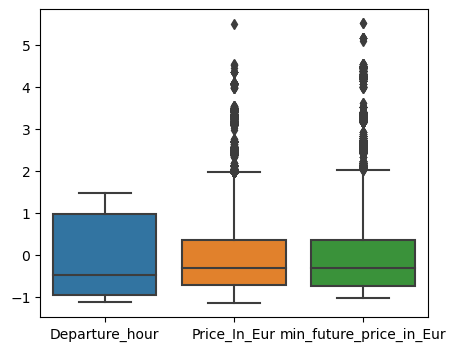

In [8]:
## Get the z-scores and create boxplots for the numerical columns

# Calculate z-scores for the numerical columns
df_train_num = df_train_copy[['Departure_hour', 'Price_In_Eur', 'min_future_price_in_Eur']]
z_scores_train = stats.zscore(df_train_num)

# Calculate z-scores for the numerical columns
z_scores_test = stats.zscore(df_train_num[['Departure_hour', 'Price_In_Eur', 'min_future_price_in_Eur']])

# Create Boxplots for the z-scores
plt.figure(figsize=(5, 4))
sns.boxplot(data=z_scores_train);

In [9]:
## Get the data considered as outliers

# Get the rows with z-scores > 3
outliers_train = np.where(z_scores_train > 3)

# Get the rows in the df_train_copy that contain outliers
df_train_copy_outlier_rows = df_train_copy.iloc[outliers_train[0]]

# Check the proportion of outliers
print(len(df_train_copy_outlier_rows)/len(df_train_copy))

0.04889744570936573


There are around 4.9% outliers in the data. Before we remove or transform them, we need to check if the outliers are reasonable or not. If they are reasonable, we can keep them. If they are not reasonable, we can remove them or transform them. Therefore we look at some features and their relationship with the outliers.

In [10]:
# Check the distribution of the route_abb column for the outliers
df_train_copy_outlier_rows['route_abb'].value_counts()

STN-SXF    1899
SXF-STN    1479
STN-FRA     393
FRA-STN     318
Name: route_abb, dtype: int64

In [11]:
# Check the distribution of Departure_hour column for the outliers
df_train_copy_outlier_rows['Departure_hour'].value_counts()

19    1247
6      767
18     667
7      666
10     349
22     285
8       68
21      40
Name: Departure_hour, dtype: int64

It seems that the outliers are not random but are associated with specific routes and departure hours. This suggests that they might be extreme but valid data points. Therefore we will not remove or replace them.

In [12]:
# check the noise in the data
df_train_copy.describe()

,index,Departure_hour,Price_In_Eur,min_future_price_in_Eur,buy
count,83624.000000,83624.000000,83624.000000,83624.000000,83624.000000
mean,41812.500000,12.969889,71.965080,56.593014,0.223835
std,24140.313792,6.177936,54.788483,46.126909,0.416815
min,1.000000,6.000000,8.990000,8.990000,0.000000
25%,20906.750000,7.000000,32.770000,22.270000,0.000000
50%,41812.500000,10.000000,55.080000,41.890000,0.000000
75%,62718.250000,19.000000,91.790000,73.430000,0.000000
max,83624.000000,22.000000,372.960000,311.090000,1.000000


-  *Departure_hour*: earliest departure hour is 6 (6 am), latest departure hour is 22 (10pm). Mean is 13 (1 pm).
-  *Price_In_Eur*: minimum price is 8.99€, maximum price is 372.96€. Average price is 72€.
-  *min_future_price_in_Eur*: minimum minimum future price is 8.99€, maximum minimum future price is 311.09€. Average minimum future price is 57€.
-  *buy*: is a boolean value. Therefore the description is not very meaningful except we can see, that more flights in the data were recommended to wait than to buy.

Now we want to dig deeper into the data and see if we can find any interesting insights that we can use to improve our model. Therefore we will have a look at each feature. Those include:   
- *Price_In_Eur*             
- *min_future_price_in_Eur*  
- *Request_Date*               
- *Flight_Date*                
- *Departure_hour*             
- *route_abb*                 
- *buy*                  
- *flight_unique_id*                 

### Price in Eur ###

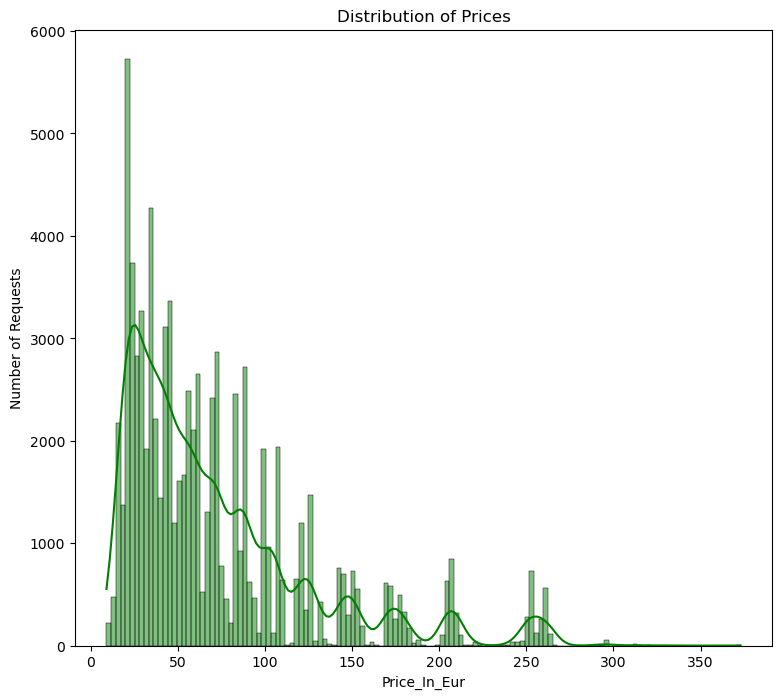

In [13]:
# check the distribution of Price in Euro
plt.figure(figsize=(9, 8))
sns.histplot(df_train_copy['Price_In_Eur'], color='g', kde=True);

plt.title('Distribution of Prices')
plt.ylabel('Number of Requests')
plt.show()

The prices seem to be quite evenly distributed. There are fluctuations in the higher prices that seem to be repeated. Also there seems to be some more expensive flights in prices around and above 350€.

### Min Future Price in Eur ###

*min_future_price_in_Eur* is a useful target variable for our model, if we want to train a regression model, because if this value is less then the current price, then we can say that it might be better to wait to buy the ticket. If this value is greater then the current price, then we can say that it might be better to buy the ticket now.

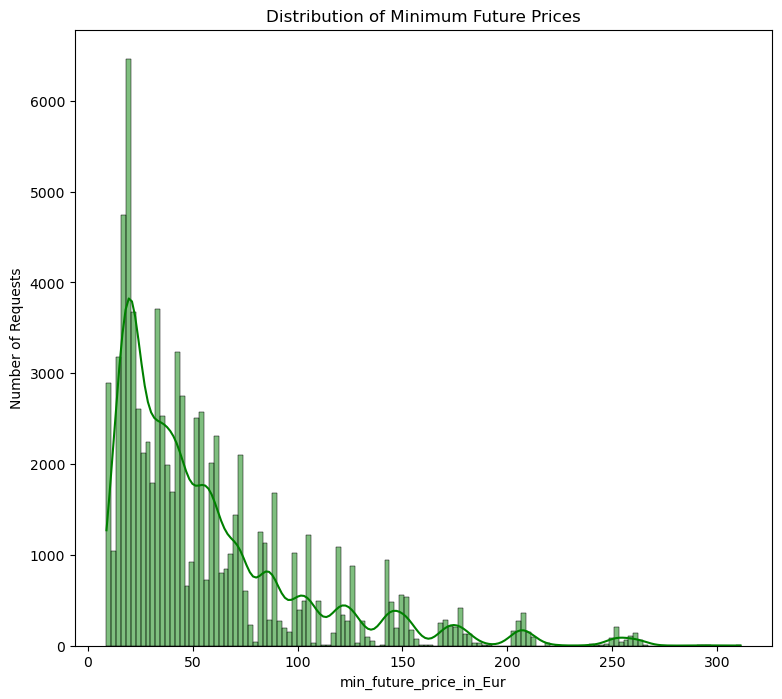

In [14]:
# check distribution of min_future_price_in_eur
plt.figure(figsize=(9, 8))
sns.histplot(df_train_copy['min_future_price_in_Eur'], color='g', kde=True);

plt.title('Distribution of Minimum Future Prices')
plt.ylabel('Number of Requests')
plt.show()

The min_future_price_in_Eur distribution nearly looks exactly like the Price_in_Eur distribution. This is as expected, since the min_future_price_in_Eur is the minimum price (Price_In_Eur) of the flight in the future.

### Request Date ###

We already have seen, that Request_Date is of type object. Therefore we need to convert it to datetime format so that we can extract information like day or month from it.

In [15]:
# check the last date in the data
print(df_train_copy['Request_Date'].min())
print(df_train_copy['Request_Date'].max())

2019-06-03T11:00:00Z
2019-08-03T11:00:00Z


The data contains requests from 2019-06-03 to 2019-08-03.

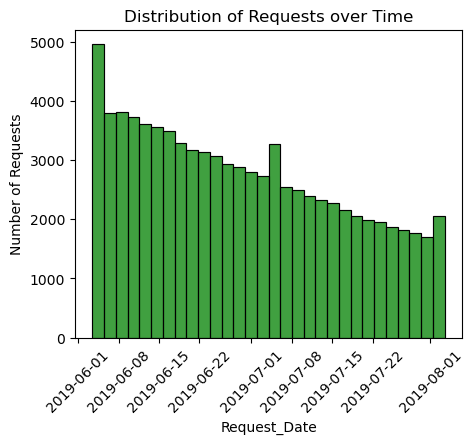

In [16]:
# check the distribution of the request date
# convert the request date to datetime
df_train_copy['Request_Date'] = pd.to_datetime(df_train_copy['Request_Date'])

plt.figure(figsize=(5, 4))
sns.histplot(df_train_copy['Request_Date'], color='g', bins=30);

plt.xticks(rotation=45);
plt.title('Distribution of Requests over Time')
plt.ylabel('Number of Requests')
plt.show()

The bars decrease in height over time, which means that the number of requests decrease over the given time period. This could be because there may be less demand in the later months. But more likely it could be due to the limited data, which only contains Requests from June to August.

Maybe it is useful for the model to know in which month the flight is taking place. So we will add a new column called *Request_Month* to the dataframe.

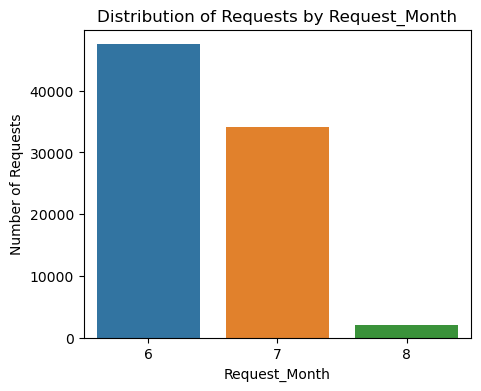

In [17]:
# Extract the month from the request date
df_train_copy['Request_Month'] = df_train_copy['Request_Date'].dt.month

# plot the request month
plt.figure(figsize=(5,4))
sns.countplot(x='Request_Month', data=df_train_copy);
plt.title('Distribution of Requests by Request_Month')
plt.ylabel('Number of Requests')
plt.show()

The data only contains requests of the months 6, 7 and 8, meaning June, July and August. The Month with the most requests is June, a little less in July and only a few in August.

Additionally it may be interesting to know, on which day of the week the request was made. This can be done by extracting the day of the week from the date of the request, we call this feature *Request_Day_Of_Week*. The day of the week is encoded as a number between 0 and 6, where 0 is Monday and 6 is Sunday.

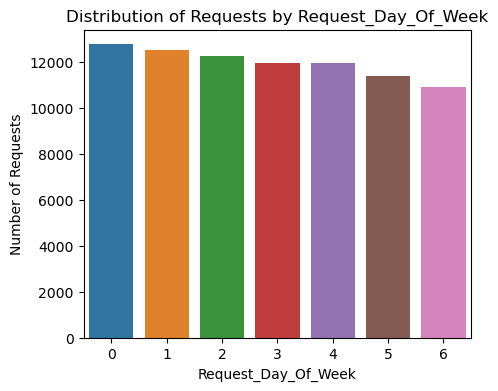

In [18]:
# Extract the day of the week from the request date
df_train_copy['Request_Day_Of_Week'] = df_train_copy['Request_Date'].dt.dayofweek
# 0 = Monday, 6 = Sunday

# plot the request day of the week
plt.figure(figsize=(5, 4))
sns.countplot(x='Request_Day_Of_Week', data=df_train_copy)
plt.title('Distribution of Requests by Request_Day_Of_Week')
plt.ylabel('Number of Requests')
plt.show()

There are nearly the same amount of requests on each day of the week.

Also, maybe it is interesting to know if the request was made on a weekend or not. So we will create a new feature called *Request_is_Weekend* which will be 1 if the request was made on a weekend and 0 if it was made on a weekday.

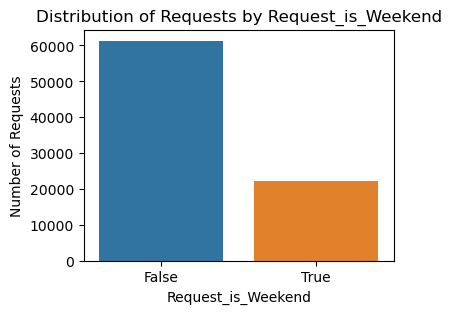

In [19]:
# create a new column to indicate if the request was made on a weekend
df_train_copy['Request_is_Weekend'] = df_train_copy['Request_Date'].dt.weekday >= 5

# plot the request is weekend
plt.figure(figsize=(4,3))
sns.countplot(x='Request_is_Weekend', data=df_train_copy)
plt.title('Distribution of Requests by Request_is_Weekend')
plt.ylabel('Number of Requests')
plt.show()

The *Request_Date* contains information regarding the time in which the request was made. With this information, we can create a new feature called *Request_Hour* which will contain the hour of the day in which the request was made.

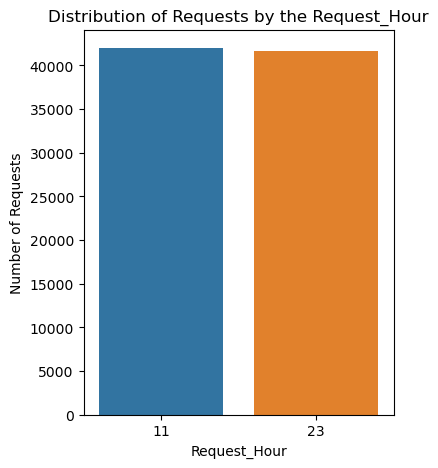

In [20]:
# extract the hour from the request date
df_train_copy['Request_Hour'] = df_train_copy['Request_Date'].dt.hour

# plot the request hour
plt.figure(figsize=(4,5))
sns.countplot(x='Request_Hour', data=df_train_copy)
plt.title('Distribution of Requests by the Request_Hour')
plt.ylabel('Number of Requests')
plt.show()

There were requests only at 11 (11 am) and at 23 (11 pm). Approximately the same number of requests were received at both times.

### Flight Date ###

Just like the *Request_Date* column, the *Flight_Date* column is also from type object. We need to convert it to datetime format.

In [21]:
# check the distribution of flight date
# convert the flight date to datetime
df_train_copy['Flight_Date'] = pd.to_datetime(df_train_copy['Flight_Date'])

In [22]:
# get the first and the last flight date
print(df_train_copy['Flight_Date'].min())
print(df_train_copy['Flight_Date'].max())

2019-06-05 00:00:00
2019-09-10 00:00:00


The first flight left on 2019-06-05 and the last flight on 2019-09-10.

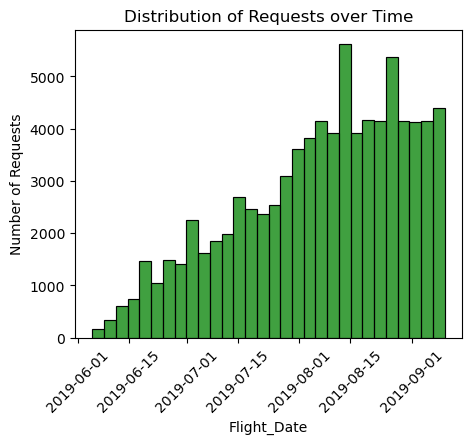

In [23]:
plt.figure(figsize=(5,4))
sns.histplot(df_train_copy['Flight_Date'], color='g', bins=30)
plt.xticks(rotation=45);
plt.title('Distribution of Requests over Time')
plt.ylabel('Number of Requests')
plt.show()

Like with Request_Date, we extract information to get the *Flight_Month*, *Flight_Day_Of_Week* and *Flight_is_Weekend*.

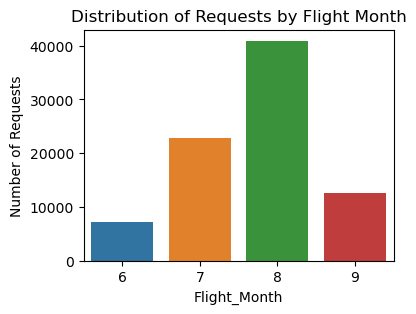

In [24]:
# Extract the month from the flight date
df_train_copy['Flight_Month'] = df_train_copy['Flight_Date'].dt.month

# plot the flight month
plt.figure(figsize=(4,3))
sns.countplot(x='Flight_Month', data=df_train_copy)
plt.title('Distribution of Requests by Flight Month')
plt.ylabel('Number of Requests')
plt.show()

Most flights depart in August, around half as many in July and only a few in September and even less in June.

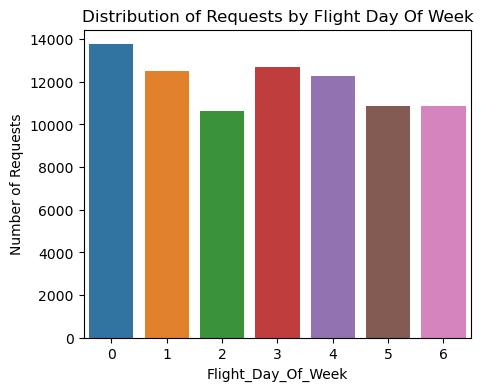

In [25]:
# Extract the day of the week from the flight date
df_train_copy['Flight_Day_Of_Week'] = df_train_copy['Flight_Date'].dt.dayofweek
# 0 = Monday, 6 = Sunday

# plot the flight day of the week
plt.figure(figsize=(5,4))
sns.countplot(x='Flight_Day_Of_Week', data=df_train_copy)
plt.title('Distribution of Requests by Flight Day Of Week')
plt.ylabel('Number of Requests')
plt.show()

The number of requests fluctuate for the different flight days of the week, meaning on some weekdays there seem to be more requests than on others.

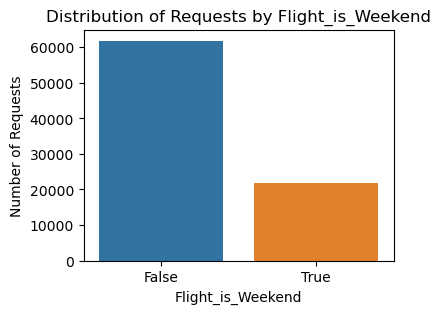

In [26]:
# create a new column to indicate if the flights are on a weekend
df_train_copy['Flight_is_Weekend'] = df_train_copy['Flight_Date'].dt.weekday >= 5

# plot the request is weekend
plt.figure(figsize=(4,3))
sns.countplot(x='Flight_is_Weekend', data=df_train_copy)
plt.title('Distribution of Requests by Flight_is_Weekend')
plt.ylabel('Number of Requests')
plt.show()

In [27]:
# check data types of flight date and request date
print(df_train_copy['Flight_Date'].dtype)
print(df_train_copy['Request_Date'].dtype)

# remove the timezone from the request date
df_train_copy['Request_Date'] = df_train_copy['Request_Date'].dt.tz_convert(None)

# check dates, where the flight date is before the request date
flight_date_before_request_date = df_train_copy[df_train_copy['Flight_Date'] < df_train_copy['Request_Date']]

print(flight_date_before_request_date.shape[0])

datetime64[ns]
datetime64[ns, UTC]
0


The Flight Dates seems to be valid since there are no Flights where the *Flight_Date* is before the *Request_Date*.

### New Feature: Days between request date and flight date ###

The time between the Request and the departure of the flight might be an indicator for the current price. Therefore we create a new column *days_between_request_and_flight*.

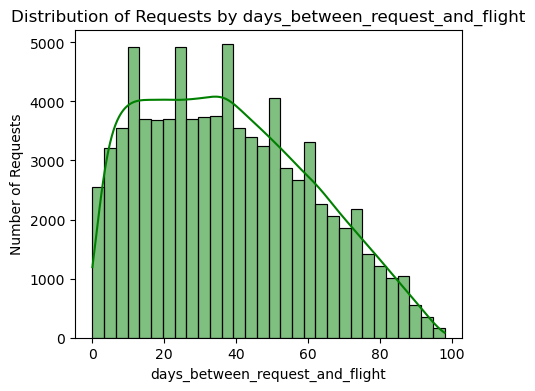

count    83624.000000
mean        37.913601
std         22.859873
min          0.000000
25%         19.000000
50%         36.000000
75%         55.000000
max         98.000000
Name: days_between_request_and_flight, dtype: float64


In [28]:
# check the distribution of the number of days between request date and flight date
df_train_copy['days_between_request_and_flight'] = (df_train_copy['Flight_Date'] - df_train_copy['Request_Date']).dt.days

plt.figure(figsize=(5,4))
sns.histplot(df_train_copy['days_between_request_and_flight'], color='g', kde=True, bins=30)
plt.title('Distribution of Requests by days_between_request_and_flight')
plt.ylabel('Number of Requests')
plt.show()

# get the min, max, mean and median of the number of days between request date and flight date
print(df_train_copy['days_between_request_and_flight'].describe())

There are between 0 and 98 days between the request date and the flight date.

### Departure Hour ###

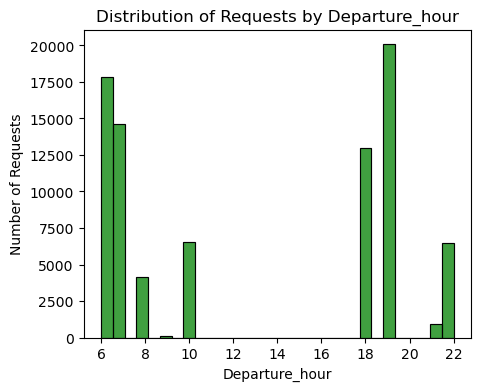

In [29]:
# check the distribution of Departure hour
plt.figure(figsize=(5,4))
sns.histplot(df_train_copy['Departure_hour'], color='g')
plt.title('Distribution of Requests by Departure_hour')
plt.ylabel('Number of Requests')
plt.show()

The earliest flights depart at 6, the latest at 22. Most flights seem to depart in the morning or in the evening. There are no flights departing in the afternoon between 12 and 16.

### New Feature: Is Holiday ###

As it is possible that the price of flights is higher on bank holidays or during school holidays, we will look at both of these information.

#### Bank Holidays ####

The data for the bank holidays is taken from the python package holidays. The data contains bank holidays for different countries. The data for holidays in germany and uk is then merged with the data from the flights.

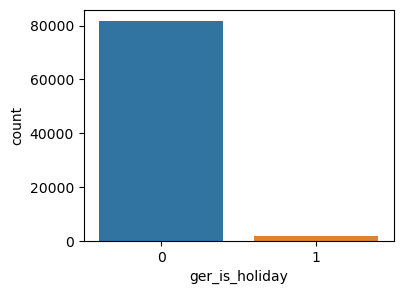

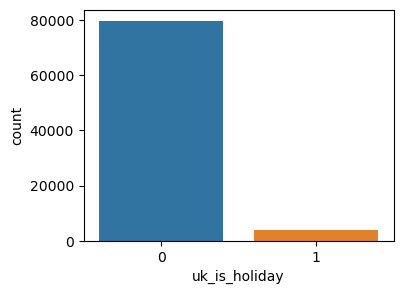

In [30]:
import holidays

ger_holidays = holidays.GR()
# create a function to check if a date is a holiday in germany
def is_holiday_ger(date):
    if date in ger_holidays:
        return 1
    else:
        return 0

# create a new column with the holiday information
df_train_copy['ger_is_holiday'] = df_train_copy['Flight_Date'].apply(is_holiday_ger)

# check the distribution of is_holiday
plt.figure(figsize=(4,3))
sns.countplot(x='ger_is_holiday', data=df_train_copy);


uk_holidays = holidays.UK()
# create a function to check if a date is a holiday in the UK
def is_holiday_uk(date):
    if date in uk_holidays:
        return 1
    else:
        return 0

# create a new column with the holiday information
df_train_copy['uk_is_holiday'] = df_train_copy['Flight_Date'].apply(is_holiday_uk)

# check the distribution of is_holiday
plt.figure(figsize=(4,3))
sns.countplot(x='uk_is_holiday', data=df_train_copy);

There are only a few bank holidays in the data (a few in germany, none in the uk) so the two holiday columns for the different countries are combined to one column. The new column contains the information if the flight is on a bank holiday (it doesn't matter if in the departure or arrival country) or not.

In [31]:
# function to check if a date is a holiday in the UK or Germany
def is_bank_holiday_uk_ger(date):
    if date in ger_holidays or date in uk_holidays:
        return 1
    else:
        return 0

# merge the two holiday columns into one
df_train_copy['is_bank_holiday'] = df_train_copy['Flight_Date'].apply(is_bank_holiday_uk_ger)

# drop the two seperate bank holiday columns for ger and uk
df_train_copy.drop(['ger_is_holiday', 'uk_is_holiday'], axis=1, inplace=True)

#### School holidays ####

Flight prices may be higher during the school holidays, because more people have the opportunity to go on vacation. Because the flights arrival and departure airports are in Germany and UK, the school holidays for these countries are added to the data [1, 2]. Because in Germany the school holidays are different for each state, the school holidays for the state of the departure airport are added to the data, meaning Berlin (and Brandenburg because it is close to Berlin) and Nordrhein-Westfalen (NRW). Only if the flight is in the school holidays of the departure or arrival airport, the flight is marked as a flight during the school holidays.

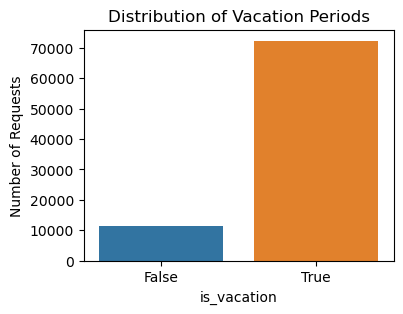

In [32]:
def is_vacation(df):
    vacations = [
        {'start': '2019-07-15', 'end': '2019-08-27', 'airports': ['FRA']},  # NRW
        {'start': '2019-05-31', 'end': '2019-06-11', 'airports': ['SXF']},  # Berlin
        {'start': '2019-06-20', 'end': '2019-08-02', 'airports': ['SXF']},  # Berlin
        {'start': '2019-06-20', 'end': '2019-08-03', 'airports': ['SXF']},  # Brandenburg
        {'start': '2019-07-15', 'end': '2019-09-06', 'airports': ['STN']}   # UK
    ]

    # Convert the start and end dates to datetime
    for vacation in vacations:
        vacation['start'] = pd.to_datetime(vacation['start'])
        vacation['end'] = pd.to_datetime(vacation['end'])

    # Extract the Departure_airport and Arrival_airport from the route_abb column
    df['departure_airport'] = df['route_abb'].str[:3]
    df['arrival_airport'] = df['route_abb'].str[-3:]

    # Initialize a new column 'is_vacation' with False
    df['is_vacation'] = False

    # Set 'is_vacation' to True if the flight date is within any of the vacation periods
    # and the origin or destination airport is associated with the vacation
    for vacation in vacations:
        df.loc[(df['Flight_Date'] >= vacation['start']) & (df['Flight_Date'] <= vacation['end']) &
               ((df['departure_airport'].isin(vacation['airports'])) | (df['arrival_airport'].isin(vacation['airports']))),
               'is_vacation'] = True

    # drop the departure and arrival airport columns
    df.drop(['departure_airport', 'arrival_airport'], axis=1, inplace=True)

    return df['is_vacation']

df_train_copy['is_vacation'] = is_vacation(df_train_copy)

# plot the distribution of is_vacation
plt.figure(figsize=(4, 3))
sns.countplot(x='is_vacation', data=df_train_copy)
plt.title('Distribution of Vacation Periods')
plt.ylabel('Number of Requests')
plt.show()

There seems to be a lot more requests for flights during the vacation periods. This is probably because people are more likely to travel during the vacation periods and the date ranges only for the months July till September, which is in most countries the vacation period.

#### Merge bank holidays and school holidays ####

Because bank holidays and school holidays are sematically similar, we combine the features *is_bank_holiday* and *is_vacation* into one feature *is_holiday* and drop the other two seperate features.

In [33]:
# merge the columns 'is_holiday' and 'is_vacation' into one column
df_train_copy['is_holiday'] = df_train_copy['is_bank_holiday'] | df_train_copy['is_vacation']

# drop the column 'is_vacation'
df_train_copy.drop('is_vacation', axis=1, inplace=True)
# drop the column 'is_bank_holiday'
df_train_copy.drop('is_bank_holiday', axis=1, inplace=True)

### Route Abb ###

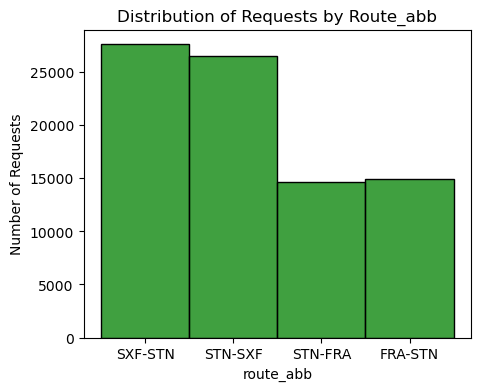

In [34]:
# check the distribution of route abb
plt.figure(figsize=(5, 4))
sns.histplot(df_train_copy['route_abb'], color='g')
plt.title('Distribution of Requests by Route_abb')
plt.ylabel('Number of Requests')
plt.show()

The data contains 2 routes: SXF-STN and STN-FRA additionally for both of those routes there are flights in both directions. There are a little more than 10000 more flights from STN-SXF/SXF-STN than from FRA-STN/STN-FRA.

It may be helpful to extract the departure and arrival airport from the route and create a new feature for it, so we can later see if the airport has an impact on the buy decision
.

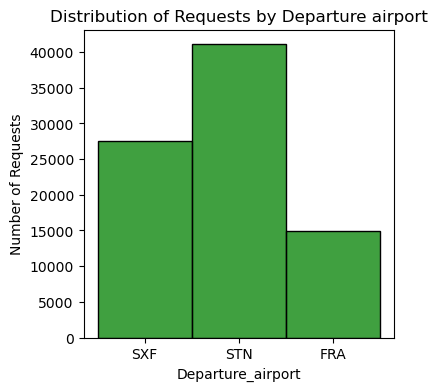

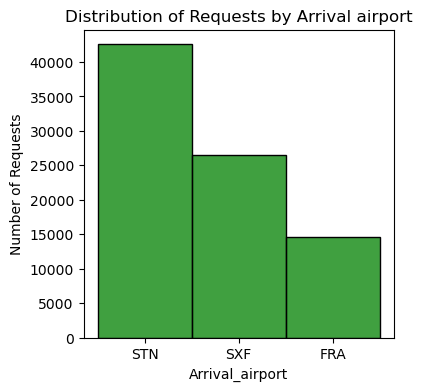

In [35]:
# Extract the departure and arrival airports from the route_abb column
df_train_copy['Departure_airport'] = df_train_copy['route_abb'].str.split('-').str[0]
df_train_copy['Arrival_airport'] = df_train_copy['route_abb'].str.split('-').str[1]

# check the distribution of Departure airport
plt.figure(figsize=(4, 4))
sns.histplot(df_train_copy['Departure_airport'], color='g')
plt.title('Distribution of Requests by Departure airport')
plt.ylabel('Number of Requests')
plt.show()

# check the distribution of Arrival airport
plt.figure(figsize=(4, 4))
sns.histplot(df_train_copy['Arrival_airport'], color='g')
plt.title('Distribution of Requests by Arrival airport')
plt.ylabel('Number of Requests')
plt.show()

Most flights seem to depart from or arrive at STN. The least common airport is FRA.

### Buy ###

The *buy* column is calculated with the columns *Price_In_Eur* and *min_future_price_in_Eur*. If the *min_future_price_in_Eur* is lower than the *Price_In_Eur* the *buy* column is set to 1, otherwise to 0. This means it is a good target variable for a classification problem.

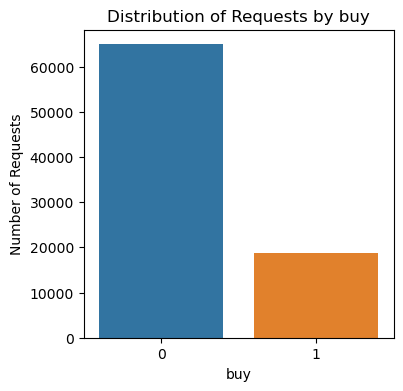

In [36]:
# check the distribution of buy
plt.figure(figsize=(4, 4))
sns.countplot(x='buy', data=df_train_copy)
plt.title('Distribution of Requests by buy')
plt.ylabel('Number of Requests')
plt.show()

There are more than three times more requests where the flight is currently not recommended to be bought than requests where the flight is recommended to be bought.

### Flight Unique Id ###

The flight_unique_id can tell us the number of requests recently made for each flight. Maybe this new feature is a good indicator to tell, if the price is going to increase or decrease. It could be that the price of an highly requestd flight is going up or down. Let's find out.

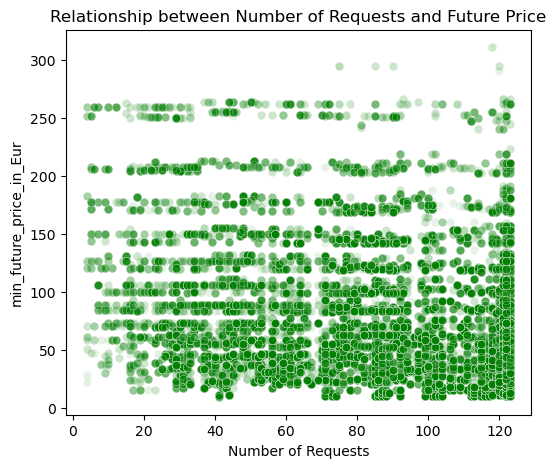

In [37]:
# check the number of requests for each flight
df_train_copy['num_requests'] = df_train_copy['flight_unique_id'].map(df_train_copy['flight_unique_id'].value_counts())

# plot the relationship between number of requests and price
plt.figure(figsize=(6, 5))
sns.scatterplot(data=df_train_copy, x='num_requests', y='min_future_price_in_Eur', alpha=0.1, color='g')
plt.title('Relationship between Number of Requests and Future Price')
plt.xlabel('Number of Requests')
plt.ylabel('min_future_price_in_Eur')
plt.show()

For some flights there seem to be a lot more requests than for others. It seems that the future price of a few flights that are relatively often requested is higher than from not so often requested flights. We investigate this correlation later on in this notebook when we look at the feature importance.

We can't use this feature for training, because it contains data, we don't have in practise. Therefore we will newly calculate the number of requests by using the rolling function to calculate the number of requests in the last 5 days.

In [38]:
def rolling_num_requests(data):
    # Sort the data by Flight_Date
    df = data.sort_values('Request_Date')

    # Calculate the number of requests in the last 5 days for each flight
    data['num_requests'] = data.groupby('flight_unique_id').rolling('5D', on='Request_Date')['Request_Date'].count().reset_index(drop=True)

    # Replace NaN values with the mean of the rest of the values in the column
    data['num_requests'].fillna(data['num_requests'].mean(), inplace=True)

    return data

df_train_copy = rolling_num_requests(df_train_copy)

Now we could use this feature for model training.

### New Feature: Rolling Mean Price ###


The current price trend may be a relevant information. If the price is currently relatively low, it may be better to buy the flight now. If the price is currently high compared to the rolling mean, it may be better to wait a little longer. Therefore we calculate the rolling mean of the price for the last 7 requests.

In [39]:
df_train_copy['rolling_mean_price'] = df_train_copy.groupby('flight_unique_id')['Price_In_Eur'].transform(lambda x: x.rolling(7, min_periods=1).mean())

Now we can look at the price trends over the time for the flights.

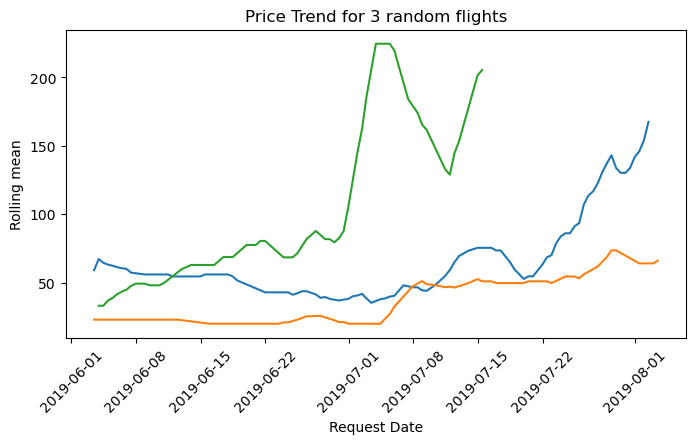

In [40]:
flight_ids = df_train_copy['flight_unique_id'].sample(3).values

plt.figure(figsize=(8, 4))

# Plot the price trend for each flight request
for flight_id in flight_ids:
    plt.plot(df_train_copy[df_train_copy['flight_unique_id'] == flight_id]['Request_Date'],
             df_train_copy[df_train_copy['flight_unique_id'] == flight_id]['rolling_mean_price'])
plt.title(f'Price Trend for 3 random flights')
plt.xlabel('Request Date')
plt.ylabel('Rolling mean')
plt.xticks(rotation=45)
plt.show()

### New feature: Price Increase Frequency ###

For the model, it could be useful to look at the price increase. I.e. determine how often the price has risen in the last 10 requests in order to see a trend, whether the price is currently rising or perhaps even falling.

In [41]:
df_train_copy['price_increase_frequency'] = df_train_copy.groupby('flight_unique_id')['Price_In_Eur'].transform(lambda x: (x.diff() > 0).rolling(10, min_periods=1).sum())

### New feature: Price difference ###

The difference between the current price and the average price for the same flight in the past could be another important parameter for the model. This allows statements on whether the price is currently very different from the average price. For example, if the price is currently much lower than the average price for this flight in past requests, it might make sense to buy the ticket now.

In [42]:
# Calculate the difference between the current price and the average price of the same flight in the past
grouped_prices = df_train_copy.groupby('flight_unique_id')['Price_In_Eur'].transform('mean')
df_train_copy['price_difference'] = df_train_copy['Price_In_Eur'] - grouped_prices

### Summary ###

The data exploration so far showed that:
-  There are no duplicates in the data
-  There are no missing values in the data
-  *Request_date* and *Flight_date* are of type object, but should be of type datetime. Request date contained the timezone information, which was removed. The data was then converted to datetime.
-  *Price_In_Eur*:
    -  The distribution is right-skewed, with most of the flight prices being less than 100 EUR. There are also some flights with prices up to around 375 EUR, but these are less common.
-  *Min_future_price_in_Eur*:
    -  The distribution is similar to that of 'Price_In_Eur', being right-skewed with most of the minimum future prices being less than 100 EUR. There are also some flights with minimum future prices up to around 300 EUR, but these are less common.
-  *Request_Date*:
    -  The data contains *Request_date*s from 2019-06-03 to 2019-08-03. There are no outliers. <br>
    The data only contains requests of the months 6, 7 and 8, meaning June, July and August. The Month with the most requests is June, a little less in July and only a few in August. <br>
    There are nearly the same amount of requests on each day of the week. There are no outliers.
-  *Flight_Date*:
    -  The first *Flight_date* is on 2019-06-05 and the last flight on 2019-09-10. There are no outliers.
-  *Departure_hour*:
    -  The flights depart between 6 and 22, most of them in the morning or in the evening, none between 12 and 16. There are no outliers.
-  *Route_abb*:
    -  The data contains 2 routes in *route_abb* with flights in both directions, so 4 routes: SXF-STN and STN-FRA. There are around 1.5 times more flights from STN-SXF/SXF-STN than from FRA-STN/STN-FRA. There are no outliers.
-  *Buy*:
    -  There are more than three times more flights that currently are recommended not to *buy* than flights that should be bought.
-  *Flight_unique_id*:
    -  The distribution of the number of requests per flight shows that a small number of flights account for a disproportionately high share of total requests, while the majority of flights receive only a small number of requests.

Additionally, we added some new features:
-  *Request_Month*
-  *Request_Day_Of_Week*
-  *Request_Hour*
-  *Request_is_Weekend*
-  *Flight_Month*
-  *Flight_Day_Of_Week*
-  *Flight_is_Weekend*
-  *days_between_request_and_flight*
-  *is_holiday*
-  *Departure_airport*
-  *Arrival_airport*
-  *num_requests*
-  *rolling_mean_price*
-  *price_increase_frequency*
-  *price_difference*

Let's have a look at how important the features are for our task to predict buy.

### Looking for Correlations ###

Because *min_future_price_in_eur* or *buy* can be used as the target variables, we will especially check for correlation between them and the other variables.

#### Numerical Features ####

First we get a quick overview of the correlations between the numerical features and the target variable by using the corr() method. We will further look at the correlation between the features in the following steps.

In [43]:
df_train_copy_num = df_train_copy[['Price_In_Eur', 'rolling_mean_price', 'price_difference', 'price_increase_frequency', 'days_between_request_and_flight', 'num_requests', 'buy', 'min_future_price_in_Eur']]

In [44]:
# check the correlation between the quantitative features and the target variable 'buy'
corr_matrix = df_train_copy_num.corr()
corr_matrix['buy'].sort_values(ascending=False)

buy                                1.000000
min_future_price_in_Eur            0.197882
rolling_mean_price                 0.000755
num_requests                      -0.002273
Price_In_Eur                      -0.038199
price_difference                  -0.092716
price_increase_frequency          -0.092970
days_between_request_and_flight   -0.224999
Name: buy, dtype: float64

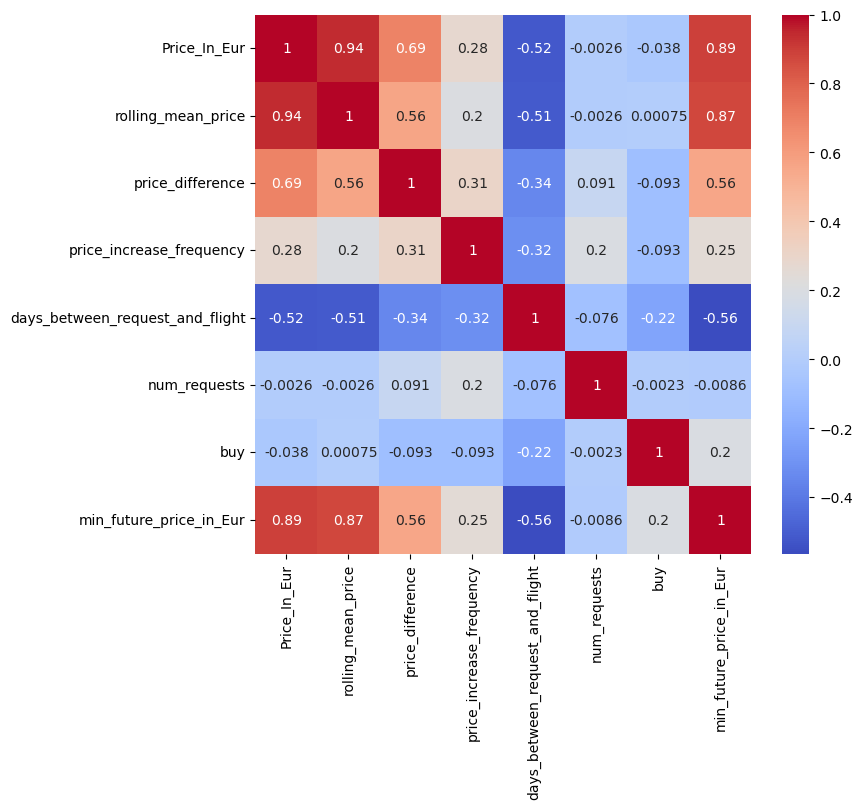

In [45]:
# Plotting correlation matrix
plt.figure(figsize = (8,7))
sns.heatmap(corr_matrix, annot = True, cmap = "coolwarm")
plt.show()

*Price_In_Eur* is highly correlated with the minimum price which makes sense, because the minimum price and the current requested price most probably are in the same price area. The same is true for *rolling_mean_price*.
*price_defference* also correlates quite strongly with *min_future_price_in_Eur*.
Just as strongly, *days_between_request_and_flight* correlates negatively with *min_future_price_in_Eur*. The *price_increase_frequency* also correlates slightly positively with the *min_future_price_in_Eur*.
*num_requests* does not seem to correlate significantly with *min_future_price_in_Eur* at first glance. We will examine the feature again for its relevance in the Select most important features step.

We can also see from the correlation matrix that all the price columns are correlated. However, since they could all contain valuable information that differs from each other, this is not a criterion for us not to include them in the model.

#### Categorical Features ####

Next, we investigate how the categorial features are correlated with the target variables *buy* and *min_future_price_in_Eur*. Because we already know that the target variables are correlated with each other, we only look at the correlation with *buy*.

In [46]:
# get the categorical features
df_train_copy_cat = df_train_copy[['buy', 'route_abb', 'Departure_airport', 'Arrival_airport', 'Departure_hour', 'Request_Month', 'Request_Day_Of_Week', 'Request_Hour', 'Request_is_Weekend', 'Flight_Month', 'Flight_Day_Of_Week', 'Flight_is_Weekend', 'is_holiday']]

##### **Route** #####

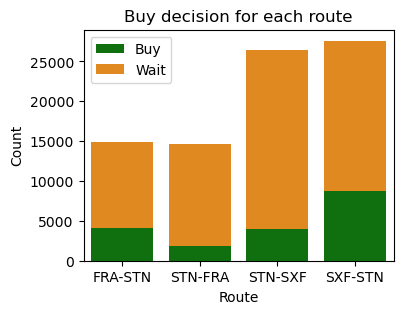

In [47]:
# Check the correlation between route_abb and the target variable 'buy'
buy_route_counts = df_train_copy_cat.groupby(['route_abb', 'buy']).size().unstack()

# Plot the data
plt.figure(figsize=(4, 3))
sns.barplot(x=buy_route_counts.index, y=buy_route_counts[1], label='Buy', color='g')
sns.barplot(x=buy_route_counts.index, y=buy_route_counts[0], bottom=buy_route_counts[1], label='Wait', color='darkorange')

plt.xlabel('Route')
plt.ylabel('Count')
plt.title('Buy decision for each route')
plt.legend()
plt.show()

There seems to be no big influence of the route on the buy decision. Maybe this can be helpful for the prediction.

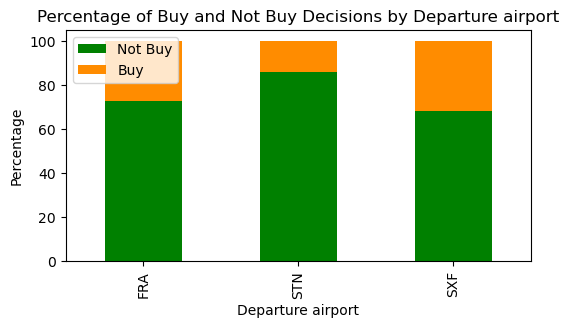

In [48]:
# Calculate the count of 'buy' and 'not buy' decisions for each Departure_airport
buy_counts = df_train_copy_cat.groupby(['Departure_airport', 'buy']).size().unstack()

# Normalize to get the proportion and multiply by 100 to get percentage
buy_percentage = (buy_counts.T / buy_counts.T.sum()).T * 100

# Create a stacked bar plot
buy_percentage.plot(kind='bar', stacked=True, figsize=(6, 3), color=['g', 'darkorange'])
plt.title('Percentage of Buy and Not Buy Decisions by Departure airport')
plt.xlabel('Departure airport')
plt.ylabel('Percentage')
plt.legend(['Not Buy', 'Buy'], loc='upper left')
plt.show()

It seems that there are a bit different amounts of buy-decisions for each Departure airport. Maybe this can be helpful for the prediction.

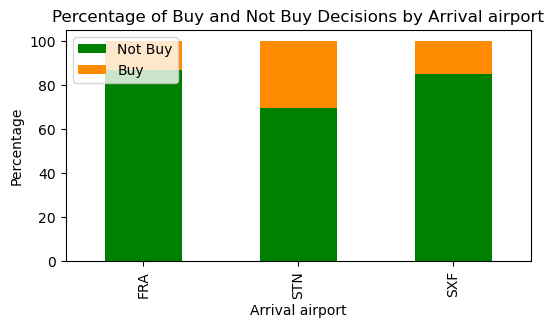

In [49]:
# Calculate the count of 'buy' and 'not buy' decisions for each Arrival_airport
buy_counts = df_train_copy_cat.groupby(['Arrival_airport', 'buy']).size().unstack()

# Normalize to get the proportion and multiply by 100 to get percentage
buy_percentage = (buy_counts.T / buy_counts.T.sum()).T * 100

# Create a stacked bar plot
buy_percentage.plot(kind='bar', stacked=True, figsize=(6, 3), color=['g', 'darkorange'])
plt.title('Percentage of Buy and Not Buy Decisions by Arrival airport')
plt.xlabel('Arrival airport')
plt.ylabel('Percentage')
plt.legend(['Not Buy', 'Buy'], loc='upper left')
plt.show()

It seems that there are a bit different amounts of buy-decisions for each Arrival airport.

##### **Departure time** #####

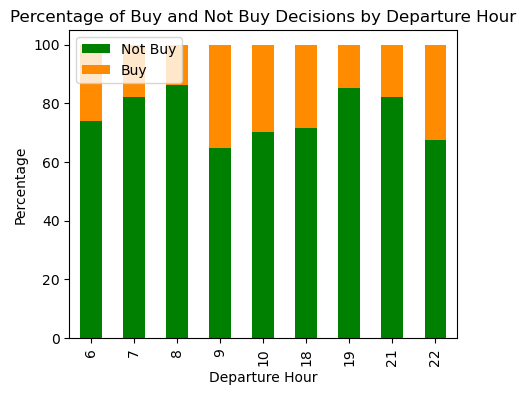

In [50]:
# Check the correlation between Departure_hour and the target variable 'buy'
buy_counts = df_train_copy_cat.groupby(['Departure_hour', 'buy']).size().unstack()

buy_percentage = (buy_counts.T / buy_counts.T.sum()).T * 100

buy_percentage.plot(kind='bar', stacked=True, figsize=(5, 4), color=['g', 'darkorange'])
plt.title('Percentage of Buy and Not Buy Decisions by Departure Hour')
plt.xlabel('Departure Hour')
plt.ylabel('Percentage')
plt.legend(['Not Buy', 'Buy'], loc='upper left')
plt.show()

It seems that the percentage of buy-reccomendation is higher for departure hours in the late morning as well as the early afternoon and late evening.

##### **Holiday** #####

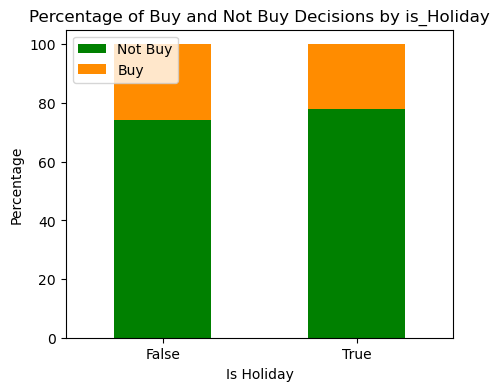

In [51]:
# Calculate the count of 'buy' and 'not buy' decisions for each holiday status
buy_counts = df_train_copy_cat.groupby(['is_holiday', 'buy']).size().unstack()

# Normalize to get the proportion and multiply by 100 to get percentage
buy_percentage = (buy_counts.T / buy_counts.T.sum()).T * 100

# Create a stacked bar plot
buy_percentage.plot(kind='bar', stacked=True, figsize=(5, 4), color=['g', 'darkorange'])
plt.title('Percentage of Buy and Not Buy Decisions by is_Holiday')
plt.xlabel('Is Holiday')
plt.ylabel('Percentage')
plt.legend(['Not Buy', 'Buy'], loc='upper left')
plt.xticks(rotation=0)
plt.show()

The proportions of buy-reccomedation and not-buy-reccomedation for the feature is_Holiday seem to be quite the same. Therefore we can't say that this feature is a good predictor for the target variable.

##### **Request Time Data** #####

**Request_Month**

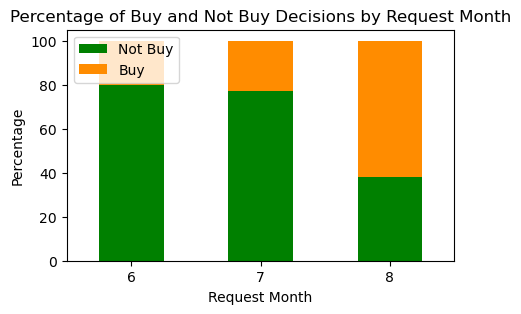

In [52]:
# Calculate the count of 'buy' and 'not buy' decisions for each Request_Month
buy_counts = df_train_copy_cat.groupby(['Request_Month', 'buy']).size().unstack()

# Normalize to get the proportion and multiply by 100 to get percentage
buy_percentage = (buy_counts.T / buy_counts.T.sum()).T * 100

# Create a stacked bar plot
buy_percentage.plot(kind='bar', stacked=True, figsize=(5, 3), color=['g', 'darkorange'])
plt.title('Percentage of Buy and Not Buy Decisions by Request Month')
plt.xlabel('Request Month')
plt.ylabel('Percentage')
plt.legend(['Not Buy', 'Buy'], loc='upper left')
plt.xticks(rotation=0)
plt.show()

There seem to be a higher percentage of buy-decisions for requests made in August. This could be a consequense of the data, which only contains data for flights departing in September latest. But this doesn't have to be the only explanation.

**Request_Day_Of_Week**

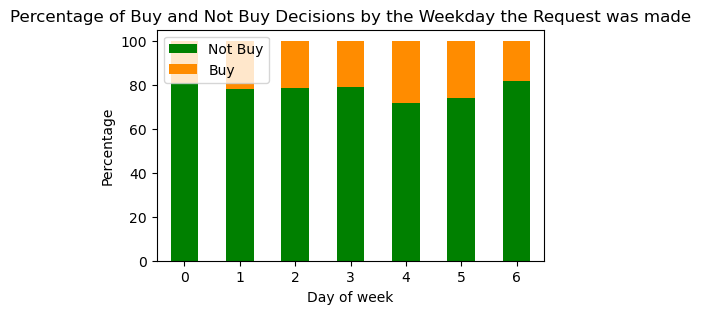

In [53]:
# Calculate the count of 'buy' and 'not buy' decisions for each Request_Day_Of_Week
buy_counts = df_train_copy_cat.groupby(['Request_Day_Of_Week', 'buy']).size().unstack()

# Normalize to get the proportion and multiply by 100 to get percentage
buy_percentage = (buy_counts.T / buy_counts.T.sum()).T * 100

# Create a stacked bar plot
buy_percentage.plot(kind='bar', stacked=True, figsize=(5, 3), color=['g', 'darkorange'])
plt.title('Percentage of Buy and Not Buy Decisions by the Weekday the Request was made')
plt.xlabel('Day of week')
plt.ylabel('Percentage')
plt.legend(['Not Buy', 'Buy'], loc='upper left')
plt.xticks(rotation=0)
plt.show()

There seems to be no big differences in the proportions and therefore no clear correlation.

**Request_Hour**

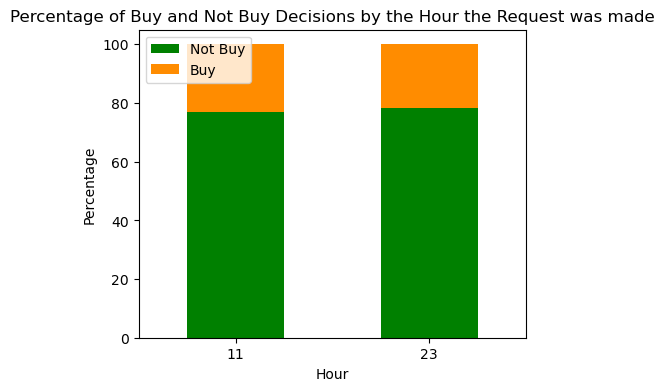

In [54]:
# Calculate the count of 'buy' and 'not buy' decisions for each Request_Hour status
buy_counts = df_train_copy_cat.groupby(['Request_Hour', 'buy']).size().unstack()

# Normalize to get the proportion and multiply by 100 to get percentage
buy_percentage = (buy_counts.T / buy_counts.T.sum()).T * 100

# Create a stacked bar plot
buy_percentage.plot(kind='bar', stacked=True, figsize=(5,4), color=['g', 'darkorange'])
plt.title('Percentage of Buy and Not Buy Decisions by the Hour the Request was made')
plt.xlabel('Hour')
plt.ylabel('Percentage')
plt.legend(['Not Buy', 'Buy'], loc='upper left')
plt.xticks(rotation=0)
plt.show()

There seems to be no big differences in the proportions and therefore no clear correlation.

**Request_is_Weekend**

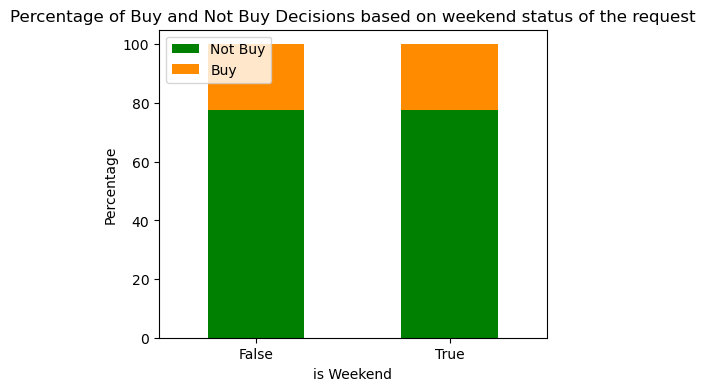

In [55]:
# Calculate the count of 'buy' and 'not buy' decisions for each Request_is_Weekend status
buy_counts = df_train_copy_cat.groupby(['Request_is_Weekend', 'buy']).size().unstack()

# Normalize to get the proportion and multiply by 100 to get percentage
buy_percentage = (buy_counts.T / buy_counts.T.sum()).T * 100

# Create a stacked bar plot
buy_percentage.plot(kind='bar', stacked=True, figsize=(5,4), color=['g', 'darkorange'])
plt.title('Percentage of Buy and Not Buy Decisions based on weekend status of the request')
plt.xlabel('is Weekend')
plt.ylabel('Percentage')
plt.legend(['Not Buy', 'Buy'], loc='upper left')
plt.xticks(rotation=0)
plt.show()

There seems to be no big differences in the proportions and therefore no clear correlation.

##### **Flight Time Data** #####

**Flight_Month**

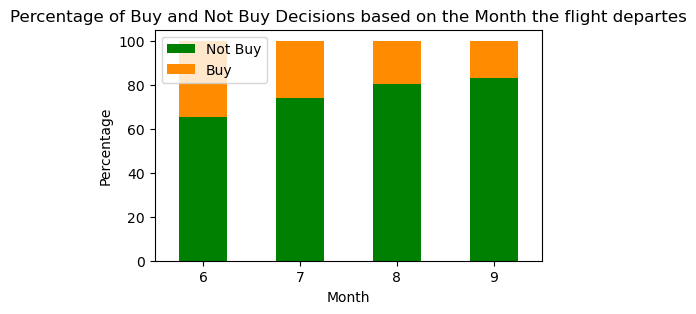

In [56]:
# Calculate the count of 'buy' and 'not buy' decisions for each Flight_Month
buy_counts = df_train_copy_cat.groupby(['Flight_Month', 'buy']).size().unstack()

# Normalize to get the proportion and multiply by 100 to get percentage
buy_percentage = (buy_counts.T / buy_counts.T.sum()).T * 100

# Create a stacked bar plot
buy_percentage.plot(kind='bar', stacked=True, figsize=(5,3), color=['g', 'darkorange'])
plt.title('Percentage of Buy and Not Buy Decisions based on the Month the flight departes')
plt.xlabel('Month')
plt.ylabel('Percentage')
plt.legend(['Not Buy', 'Buy'], loc='upper left')
plt.xticks(rotation=0)
plt.show()

There seems to be more buy recommendations for flights that departe earlier in the year. This could be due to the fact, that we only have a limited range of months contained in the dataset. Meaning, if we have a Flight departing at June, but we only have data for requests since June, we can't wait to buy the ticket, because the flight starts only a short time after the request. But this doesn't have to be the only reason for this decrease in buy-decisions over the year.

**Flight_Day_Of_Week**

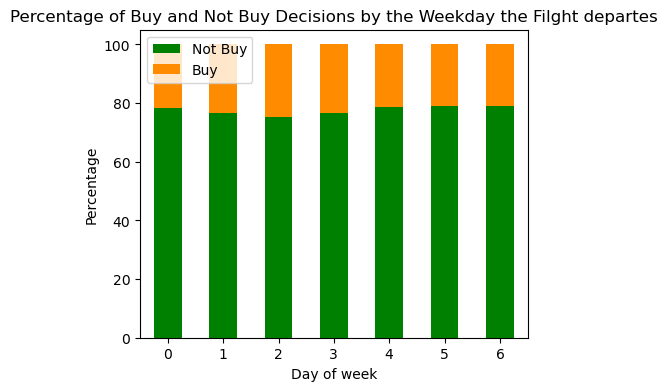

In [57]:
# Calculate the count of 'buy' and 'not buy' decisions for each Flight_Day_Of_Week
buy_counts = df_train_copy_cat.groupby(['Flight_Day_Of_Week', 'buy']).size().unstack()

# Normalize to get the proportion and multiply by 100 to get percentage
buy_percentage = (buy_counts.T / buy_counts.T.sum()).T * 100

# Create a stacked bar plot
buy_percentage.plot(kind='bar', stacked=True, figsize=(5, 4), color=['g', 'darkorange'])
plt.title('Percentage of Buy and Not Buy Decisions by the Weekday the Filght departes')
plt.xlabel('Day of week')
plt.ylabel('Percentage')
plt.legend(['Not Buy', 'Buy'], loc='upper left')
plt.xticks(rotation=0)
plt.show()

There seems to be no big differences in the proportions and therefore no clear correlation.

**Flight_is_Weekend**

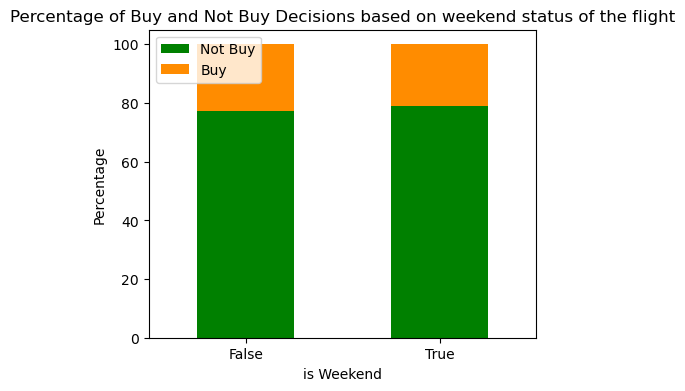

In [58]:
# Calculate the count of 'buy' and 'not buy' decisions for each Request_is_Weekend status
buy_counts = df_train_copy_cat.groupby(['Flight_is_Weekend', 'buy']).size().unstack()

# Normalize to get the proportion and multiply by 100 to get percentage
buy_percentage = (buy_counts.T / buy_counts.T.sum()).T * 100

# Create a stacked bar plot
buy_percentage.plot(kind='bar', stacked=True, figsize=(5,4), color=['g', 'darkorange'])
plt.title('Percentage of Buy and Not Buy Decisions based on weekend status of the flight')
plt.xlabel('is Weekend')
plt.ylabel('Percentage')
plt.legend(['Not Buy', 'Buy'], loc='upper left')
plt.xticks(rotation=0)
plt.show()

There seems to be no big differences in the proportions and therefore no clear correlation.

### Select most important features ###

Now, we have manually inspected the numerical and categoriel features to find features that might be important for the model.

Additionally, we will now use a method to find the most important features for the model based on the results of SelectKBest. SelectKBest takes a function, meaning a statistical test to evaluate the relationship between each feature and the target variable. The function then returns the K best features (K is freely selecteable) based on the results of the statistical test.

Because for regression and classification tasks different evaluation functions are needed, we will perform two separate investigations.

#### SelectKBest for Regression (target variable: min_future_price_in_Eur) ####

In [59]:
# copy the data
df_train_copy_kbest_reg = df_train_copy.copy()

# define the features and the target variable
X = df_train_copy.drop(['buy', 'flight_unique_id', 'route_abb', 'Request_Date', 'Flight_Date', 'min_future_price_in_Eur'], axis=1)
y = df_train_copy['min_future_price_in_Eur']

X = pd.get_dummies(X)

bestfeatures = SelectKBest(score_func=mutual_info_regression, k=20)
fit = bestfeatures.fit(X,y)

dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

# concat two dataframes for better visualization
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  # naming the dataframe columns

# print 20 best features
featureScores.nlargest(20,'Score')

,Specs,Score
0,index,5.161913
15,price_difference,3.023863
2,Price_In_Eur,2.813668
13,rolling_mean_price,1.655955
1,Departure_hour,0.792095
20,Arrival_airport_STN,0.685498
17,Departure_airport_STN,0.683052
8,Flight_Day_Of_Week,0.660822
7,Flight_Month,0.570152
10,days_between_request_and_flight,0.566647


#### SelectKBest for Classification (target variable: buy) ####

In [60]:
# copy the data
df_train_copy_kbest_cl = df_train_copy.copy()

# separate the features and the target variable 'min_future_price_in_Eur'
X = df_train_copy_kbest_cl.drop(['buy', 'Request_Date', 'Flight_Date', 'flight_unique_id'], axis=1)
Y = df_train_copy_kbest_cl['buy']

# convert the categorical columns to numerical
X = pd.get_dummies(X)

# apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=mutual_info_classif , k=20)
fit = bestfeatures.fit(X, Y)

# create a dataframe with the scores
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

# concat the two dataframes for better visualization
featureScores = pd.concat([dfcolumns, dfscores], axis=1)
featureScores.columns = ['Specs', 'Score']

# print the 20 best features
featureScores.nlargest(20, 'Score')

,Specs,Score
0,index,0.276848
16,price_difference,0.229343
3,min_future_price_in_Eur,0.084172
2,Price_In_Eur,0.079958
14,rolling_mean_price,0.057141
11,days_between_request_and_flight,0.037713
22,Departure_airport_STN,0.024298
25,Arrival_airport_STN,0.021851
1,Departure_hour,0.017164
20,route_abb_SXF-STN,0.014247


The results of the two SelectKBest-runs align mostly with our previously findings, so we select the following features for our model training:

- *Departure_hour*	
- *Price_In_Eur*	
- *min_future_price_in_Eur*	
- *buy*	
- *days_between_request_and_flight*	
- *flight_is_weekend*	
- *is_holiday*	
- *route_abb*	
- *price_difference*	
- *Flight_Month*	
- *Request_Month*	
- *rolling_mean_price*	
- *price_increase_frequency*	
- *num_requests*

## Prepare the Data for Model Training ##

In this step we apply the knowledge from the previous chapter, i.e. we prepare the data for training by performing the required transformations, deriving features, creating new ones and removing unneeded features.

In [61]:
df_copy = orig_df_train.copy()

In [62]:
def preprocess_dataframe(df):

    # create a copy of the original dataframe
    df_copy = df.copy()

    # Convert 'Price_In_Eur' to whole cents and store as integers to avoid floating point errors.
    df_copy['Price_In_Eur'] = df_copy['Price_In_Eur'] * 100
    df_copy['Price_In_Eur'] = df_copy['Price_In_Eur'].astype(int)

    # Convert 'Request_Date' and 'Flight_Date' to datetime format
    df_copy['Request_Date'] = pd.to_datetime(df_copy['Request_Date'], format='%Y-%m-%dT%H:%M:%SZ')
    df_copy['Flight_Date'] = pd.to_datetime(df_copy['Flight_Date'], format='%Y-%m-%d')

    # Convert 'flight_unique_id' to a numeric format
    df_copy['flight_unique_id'] = df_copy['flight_unique_id'].apply(lambda x: int(''.join(filter(str.isdigit, x))))

    return df_copy

In [63]:
df_copy = preprocess_dataframe(df_copy)

In [64]:
def feature_engineering(df):

    # Make a copy of the dataframe
    df_copy = df.copy()

    # 1. days_between_request_and_flight
    df_copy['days_between_request_and_flight'] = (df_copy['Flight_Date'] - df_copy['Request_Date']).dt.days

    # 2. flight_is_weekend
    df_copy['flight_is_weekend'] = df_copy['Flight_Date'].dt.weekday >= 5
    df_copy['flight_is_weekend'] = df_copy['flight_is_weekend'].astype(int)

    # 3. is_holiday: Flight on holiday vs. not on holiday
    df_copy['is_bank_holiday'] = df_copy['Flight_Date'].apply(is_bank_holiday_uk_ger)
    df_copy['is_vacation'] = is_vacation(df_copy)
    df_copy['is_holiday'] = df_copy['is_bank_holiday'] | df_copy['is_vacation']

    # 4. Encode the route_abb column
    route_abb_encoded = pd.get_dummies(df_copy['route_abb'], prefix='route')
    df_copy = pd.concat([df_copy, route_abb_encoded], axis=1)

    # 5. price_difference
    grouped_prices = df_copy.groupby('flight_unique_id')['Price_In_Eur'].transform('mean')
    df_copy['price_difference'] = df_copy['Price_In_Eur'] - grouped_prices

    # 6. month_flight
    df_copy['month_flight'] = df_copy['Flight_Date'].dt.month

    # 7. month_request
    df_copy['month_request'] = df_copy['Request_Date'].dt.month

    # 8. rolling_mean_price
    df_copy['rolling_mean_price'] = df_copy.groupby('flight_unique_id')['Price_In_Eur'].transform(lambda x: x.rolling(10, min_periods=1).mean())

    # 9. price_increase_frequency
    df_copy['price_increase_frequency'] = df_copy.groupby('flight_unique_id')['Price_In_Eur'].transform(lambda x: (x.diff() > 0).rolling(10, min_periods=1).sum())

    # 10. num_requests: Number of requests per flight
    df_copy['num_requests'] = df_copy.groupby('flight_unique_id').rolling('5D', on='Request_Date')['Request_Date'].count().reset_index(drop=True)
    # Replace NaN values with the mean of the rest of the values in the column
    df_copy['num_requests'].fillna(df_copy['num_requests'].mean(), inplace=True)

    # Convert boolean columns to integer
    for col in df_copy.columns:
        if df_copy[col].dtype == bool:
            df_copy[col] = df_copy[col].astype(int)

    # Drop columns which will not be used in modeling
    df_copy = df_copy.drop(columns=['Flight_Date', 'route_abb', 'index', 'is_vacation', 'is_bank_holiday'])

    return df_copy

In [65]:
df_copy = feature_engineering(df_copy)
df_copy.head()

,Request_Date,Departure_hour,flight_unique_id,Price_In_Eur,min_future_price_in_Eur,buy,days_between_request_and_flight,flight_is_weekend,is_holiday,route_FRA-STN,route_STN-FRA,route_STN-SXF,route_SXF-STN,price_difference,month_flight,month_request,rolling_mean_price,price_increase_frequency,num_requests
0,2019-06-03 11:00:00,19,20190605146,20807,259.07,1,1,0,1,0,0,0,1,-3825.0,6,6,20807.0,0.0,1.0
1,2019-06-03 23:00:00,19,20190605146,25907,259.07,1,1,0,1,0,0,0,1,1275.0,6,6,23357.0,1.0,2.0
2,2019-06-04 11:00:00,19,20190605146,25907,259.07,1,0,0,1,0,0,0,1,1275.0,6,6,24207.0,1.0,3.0
3,2019-06-04 23:00:00,19,20190605146,25907,259.07,1,0,0,1,0,0,0,1,1275.0,6,6,24632.0,1.0,4.0
4,2019-06-03 11:00:00,21,20190605147,14386,251.72,1,1,0,1,0,0,1,0,-8098.0,6,6,14386.0,0.0,1.0


Now, the data is ready to be used for model training.

## Model Selection ##

In the model selection phase, we try out different models and optimize their hyperparameters to choose the most suitable machine learning algorithm for our specific problem, based on the outcomes of the data preparation and feature selection process.<br>
But before we start with the model training, we have to make clear what the model should predict. Based on the interim presentations and the input we got from them about the project and the approach, we have decided to train 2 different models. The idea is as follows: The final goal is to predict buy, for that we will use a classification model. But to make this decision in the best possible way, it would be helpful to know the min_future_price_in_Eur, so we can say if the ticket will become cheaper. However, since this feature is logically not included in the real data, we will first train a regression model that predicts this value. For practical use, this means that the min_future_price_in_Eur is first predicted for the real data and then the Classifier is used on the real data combined with the min_future_price_in_Eur-Prediction to predict to buy or not to buy. [TODO Quelle Gruppe E]

#### Model Quality Evaluation Function by Prof. Spott ####

To calculate whether a model is good and makes good buy-suggestions, we use a custom metric which was provided by Prof. Dr. Martin Spott. The concept of this quality measurement is at follows:

It could be that 9 times out of 10 we correctly predict that it is best to buy the ticket now. But then the one time we wrongly give a buy recommendation, the ticket price is currently very high and we make a big loss. In contrast, it could be that we have only saved minimally on the 9 correct predictions. This encompasses the model quality evaluation function. [TODO: Quelle Spott]

We will later use it to calculate the economic quality of our models.

In [66]:
# The model quality evaluation function expects a Pandas dataframe with at least the following columns:
# Request_Date          int64
# flight_unique_id     object
# Price               float64
# buy                    bool

def model_quality_evaluation(df):
    # Make a copy of the provided dataframe as to not modify the original.
    df = df.copy()

    # Convert 'Price' to whole cents and store as integers to avoid floating point errors.
    df['Price'] = df['Price'] * 100
    df['Price'] = df['Price'].astype(int)

    # Initialize a variable that stores the sum of all our balances.
    sum_balances = 0

    # Get a list of all 'flight_unique_id'.
    flight_unique_ids = df['flight_unique_id'].unique()

    # Iterate over all 'flight_unique_id'.
    for flight_unique_id in flight_unique_ids:
        # Get a subset of the data for the specified 'flight_unique_id'.
        df_subset = df[df['flight_unique_id'] == flight_unique_id]

        # Get all request dates except for the latest request date before departure.
        # At the latest request date before departure we need to buy a ticket anyway,
        # so we don't care about this specific request date.
        request_dates = df_subset[df_subset['Request_Date'] != df_subset['Request_Date'].max()]

        # Make sure request dates are sorted in descending order.
        request_dates.sort_values(by='Request_Date', ascending=False, inplace=True)

        # Get the ticket price from the latest request date before departure,
        # because we certainly have to buy a ticket at this date.
        last_buying_price = df_subset[df_subset['Request_Date'] == df_subset['Request_Date'].max()]['Price'].values[0]

        # Iterate over the remaining request dates
        for _, row in request_dates.iterrows():
            # and check wether the model wants to buy a ticket at the specific request date.
            if(row['buy'] == True):
                # If the model decides to buy a ticket the last buying price is set to the
                # price point of this request date and the balance doesn't change.
                last_buying_price = row['Price']
            else:
                # If the models decides to not buy a ticket the balance equals the
                # the current ticket price minus the last buying price.
                current_price = row['Price']
                balance = current_price - last_buying_price

                # The balance is added to the sum of all balances.
                sum_balances = sum_balances + balance

    # Return the sum of all our previously calculated balances.
    return sum_balances / 100

#### Define helper functions for quality evaluation ####

In the model training, we want to investigate different metrics, not only the custom model quality evaluation function we previously defined.
To evaluate the regression models, we will look at the MSE and the R2-score. 
We want to look at the classification model's performance in terms of accuracy, precision, recall, ROC AUC, F1-score and the custom score, meaning the economic quality. Additionally, we want to look at the confusion matrix to see how many false positives and false negatives we have. Finally, we want to look at the ROC-curve to see how the true positive rate and false positive rate change with the threshold. 
For all these metrics, we defined helper functions we can call in the model training easily.

In [67]:
# Create a function to calculate the metrics for regression
def calculate_metrics_reg(y_test, y_pred):
    return {
        'mse': round(mean_squared_error(y_test, y_pred), 4),
        'r2': round(r2_score(y_test, y_pred), 4),
        }

# Create a function to calculate the metrics for classification
def calculate_metrics(y_test, y_pred):
    return {
        'acc': accuracy_score(y_test, y_pred),
        'prec': precision_score(y_test, y_pred),
        'rec': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'roc': roc_auc_score(y_test, y_pred)
    }

# Create a function to plot the confusion matrizes
def plot_confusion_matrices(y_test, preds_list, model_names):
    n_models = len(preds_list)
    n_rows = (n_models - 1) // 3 + 1
    n_cols = min(n_models, 3)
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 3 * n_rows))
    
    if n_rows == 1 and n_cols == 1:
        axes = np.array([[axes]])
    elif n_rows == 1:
        axes = np.array([axes])
    
    for idx, (y_pred, name) in enumerate(zip(preds_list, model_names)):
        row, col = divmod(idx, 3)
        ax = axes[row][col]
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, cmap='coolwarm', fmt='.2f', ax=ax)
        ax.set_title(name)
        ax.set_xlabel('Predicted')
        ax.set_ylabel('Actual')
    
    if n_models != n_rows * 3:
        for idx in range(n_models, n_rows * 3):
            row, col = divmod(idx, 3)
            if row < axes.shape[0] and col < axes.shape[1]:
                fig.delaxes(axes[row][col])
    
    plt.tight_layout()
    plt.show()

# Create a function to plot the ROC Curves
def plot_roc_curves(models, X_test, y_test, model_names):

    plt.figure(figsize=(6,4))
    
    for model, name in zip(models, model_names):
        y_score = model.predict_proba(X_test)[:,1]
        
        fpr, tpr, _ = roc_curve(y_test, y_score)
        roc_auc = auc(fpr, tpr)
        
        # plot the ROC curve
        plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.4f})')
    
    plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for different models')
    plt.legend(loc="lower right", fontsize=9)
    plt.show()

# Create a helper function for custom score
def custom_score(df, df_orig, y_pred):
  val_df = df.copy()
  val_df['Request_Date'] = df_orig.loc[df.index, 'Request_Date']
  val_df['flight_unique_id'] = df_orig.loc[df.index, 'flight_unique_id']
  val_df['Price'] = df_orig.loc[df.index, 'Price_In_Eur']
  val_df['buy'] = y_pred

  # Sort the DataFrame
  val_df.sort_values(by=['flight_unique_id', 'Request_Date'], inplace=True)

  monetary_evaluation_result = model_quality_evaluation(val_df)
  return monetary_evaluation_result / 100

### Model to predict *min_future_price_in_Eur* ###

#### Define the target variable and the features ####

In [68]:
# Features and target variable
X = df_copy.drop(columns=['buy', 'min_future_price_in_Eur', 'Request_Date'])
y = df_copy['min_future_price_in_Eur']

# Splitting the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Scaling ####

Some machine learning algorithms are sensitive to the scale of the input data. For example, algorithms that use a distance measure, such as k-nearest neighbors (KNN) or support vector machines (SVM), can be affected if the features are not on the same scale. But we will use no algorithm that use distance measurements, so we don't need to scale the data.

#### Model Training ####

For predicting the *min_future_price_in_Eur*, we have chosen to train and evaluate three different models. These models were chosen based on their diverse strengths and applicabilities: <a name="geron">[1]</a> [link](#geron) TODO

*   **Linear Regression** <br>
    Linear Regression serves as an excellent starting point, being a fundamental and widely-used model. Its simplicity allows for a swift evaluation of linear relationships within the dataset. Beginning with a straightforward model helps gauge how well a basic approach can handle the data.

*   **Random Forest Regressor** <br>
    While Linear Regression operates on linear relationships, Random Forest can capture non-linear patterns in the dataset. Given that real-world data often exhibits non-linear trends, this ensemble method offers a robust technique for recognizing such patterns. Additionally, it's resilient to outliers and provides an interpretation of the significance of individual features through feature importances.

*   **Gradient Boosting Regressor** <br>
    Another ensemble method, Gradient Boosting, provides a combination of depth and breadth in modeling, often leading to superior performance. It is renowned for its ability to model intricate non-linear relationships. While it might be more prone to overfitting, this risk can be mitigated with careful hyperparameter tuning.

The models were selected to cover a broad spectrum of techniques - from simple linear relationships to intricate non-linear patterns, ensuring a comprehensive analysis of the data.

In [69]:
# Train the Linear Regression model
lr = LinearRegression()
lr.fit(X_train, y_train)

# Train the Random Forest Regressor model
rfr = RandomForestRegressor(random_state=42)
rfr.fit(X_train, y_train)

# Train the Gradient Boosting Regressor model
gbr = GradientBoostingRegressor(random_state=42)
gbr.fit(X_train, y_train)

GradientBoostingRegressor(random_state=42)

In [70]:
scoring = {'mse': 'neg_mean_squared_error', 'r2': 'r2'}

lr_scores = cross_validate(lr, X_train, y_train, scoring=scoring, cv=5)
rfr_scores = cross_validate(rfr, X_train, y_train, scoring=scoring, cv=5)
gbr_scores = cross_validate(gbr, X_train, y_train, scoring=scoring, cv=5)

# print the mean of the scores
table = PrettyTable()
table.field_names = ['Model', 'MSE', 'R2']

table.add_row(['Linear Regression', round(lr_scores['test_mse'].mean(), 4), round(lr_scores['test_r2'].mean(), 4)])
table.add_row(['Random Forest Regressor', round(rfr_scores['test_mse'].mean(), 4), round(rfr_scores['test_r2'].mean(), 4)])
table.add_row(['Gradient Boosting Regressor', round(gbr_scores['test_mse'].mean(), 4), round(gbr_scores['test_r2'].mean(), 4)])

table

Model,MSE,R2
Linear Regression,-367.8182,0.8286
Random Forest Regressor,-139.8557,0.9348
Gradient Boosting Regressor,-246.9439,0.8849


In [71]:
# Compute the scores for the Linear Regression model
lr_train_pred = lr.predict(X_train)
lr_test_pred = lr.predict(X_test)

lr_train_scores = calculate_metrics_reg(y_train, lr_train_pred)
lr_test_scores = calculate_metrics_reg(y_test, lr_test_pred)


# Compute the scores for the Random Forest Regressor model
rfr_train_pred = rfr.predict(X_train)
rfr_test_pred = rfr.predict(X_test)

rfr_train_scores = calculate_metrics_reg(y_train, rfr_train_pred)
rfr_test_scores = calculate_metrics_reg(y_test, rfr_test_pred)


# Compute the scores for the Gradient Boosting Regressor model
gbr_train_pred = gbr.predict(X_train)
gbr_test_pred = gbr.predict(X_test)

gbr_train_scores = calculate_metrics_reg(y_train, gbr_train_pred)
gbr_test_scores = calculate_metrics_reg(y_test, gbr_test_pred)

In [72]:
# Make a table to compare the scores of the 3 models
table = PrettyTable()

# Add columns
table.field_names = ["Model", "Data Set", "Mean Squared Error (MSE)", "R2 Score"]

# Add rows
table.add_row(["Linear Regression", "Train Set", lr_train_scores['mse'], lr_train_scores['r2']])
table.add_row(["Linear Regression", "Test Set", lr_test_scores['mse'], lr_test_scores['r2']])
table.add_row(["Random Forest Regressor", "Train Set", rfr_train_scores['mse'], rfr_train_scores['r2']])
table.add_row(["Random Forest Regressor", "Test Set", rfr_test_scores['mse'], rfr_test_scores['r2']])
table.add_row(["Gradient Boosting Regressor", "Train Set", gbr_train_scores['mse'], gbr_train_scores['r2']])
table.add_row(["Gradient Boosting Regressor", "Test Set", gbr_test_scores['mse'], gbr_test_scores['r2']])

# Print the table
table

Model,Data Set,Mean Squared Error (MSE),R2 Score
Linear Regression,Train Set,367.6324,0.8287
Linear Regression,Test Set,349.1783,0.8299
Random Forest Regressor,Train Set,18.0599,0.9916
Random Forest Regressor,Test Set,113.7582,0.9446
Gradient Boosting Regressor,Train Set,236.878,0.8896
Gradient Boosting Regressor,Test Set,233.1833,0.8864


The Random Forest Regressor achieved the lowest MSE, followed by the Gradient Boosting Regressor and then the Linear Regression model. Additionally, the Random Forest Regressor has also the highest R2 score.
We can see that the scores from the Random Forest Regressor are much better for the training than the test set. This could mean that the model is currently overfitting the data. But nevertheless the scores indicate that the best fit for the data among the three models is the Random Forest Regressor.

Therefore we will optimize the hyperparameters for the **Random Forest Regressor** in the next step.

#### Model Tuning ####

To optimize the hyperparameters we will use an bayesian optimizer, because it is an advanced method for hyperparameter optimization based on Bayesian probability theory. Unlike traditional techniques like Grid Search or Random Search, which search the space in an unstructured manner, the Bayesian Optimizer uses previous results to intelligently decide which hyperparameter combinations should be tested next. This often leads to faster and more accurate results, especially when the search space is large. [TODO: Quelle referenzieren]

##### Random Forest Regressor

We will use the mean squared error as the score to optimize. However, this score should not be maximized, but minimized. Therefore, the score is multiplied by -1. This means that this so-called negative mean squared error is maximized, allowing us to carry out the optimization, as the bayesian optimization always tries to maximize the score.

Ideally, the CV score should be calculated at each iteration. However, this is very computationally intensive. Hence, we decided to calculate the score for the test set. While this may not be as accurate, it still serves as an indicator of whether the hyperparameters are good or not. After we retrained an optimized model, we will again compute the CV score for the best hyperparameters and compare it with the score for the test set to better evaluate the model.

In [79]:
# define the function to optimize
def optimize(n_estimators, max_depth, min_samples_split, min_samples_leaf):
    rfr = RandomForestRegressor(n_estimators=int(n_estimators),
                                  max_depth=int(max_depth),
                                  min_samples_split=int(min_samples_split),
                                  min_samples_leaf=int(min_samples_leaf),
                                  random_state=42)
    rfr.fit(X_train, y_train)

    y_pred = rfr.predict(X_test)
    return -mean_squared_error(y_test, y_pred)

In [76]:
# Initialize the optimizer
optimizer = BayesianOptimization(f=optimize, pbounds={
    'n_estimators': (10, 1000),
    'max_depth': (3, 50),
    'min_samples_split': (2, 30),
    'min_samples_leaf': (1, 30)
})

# Perform the optimization
optimizer.maximize(n_iter=20, init_points=10)

|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------


| 1         | -183.0    | 17.0      | 21.75     | 5.944     | 254.2     |
| 2         | -182.9    | 45.23     | 21.91     | 11.76     | 944.2     |
| 3         | -384.4    | 3.431     | 29.05     | 16.78     | 387.5     |
| 4         | -183.3    | 32.96     | 21.4      | 5.017     | 170.2     |
| 5         | -206.0    | 11.53     | 29.69     | 21.09     | 842.6     |
| 6         | -176.9    | 39.53     | 18.4      | 29.8      | 581.3     |
| 7         | -189.6    | 14.93     | 24.1      | 7.567     | 972.0     |
| 8         | -179.4    | 16.78     | 19.38     | 9.86      | 517.9     |
| 9         | -140.1    | 24.34     | 3.033     | 21.96     | 690.9     |
| 10        | -164.2    | 18.87     | 13.58     | 26.51     | 172.7     |
| 11        | -386.5    | 3.0       | 1.0       | 30.0      | 33.88     |
| 12        | -197.2    | 50.0      | 30.0      | 2.0       | 748.4     |
| 13        | -140.0    | 25.41     | 2.505     | 22.26     | 692.1     |
| 14        | -113.0    | 50.0      | 

In [81]:
# Initialize the optimizer
optimizer = BayesianOptimization(f=optimize, pbounds={
    'n_estimators': (550, 750),
    'max_depth': (25, 65),
    'min_samples_split': (2, 30),
    'min_samples_leaf': (1, 20)
})

# Perform the optimization
optimizer.maximize(n_iter=20, init_points=10)

|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------


| 1         | -149.7    | 50.29     | 9.719     | 5.861     | 556.3     |
| 2         | -153.5    | 31.98     | 10.28     | 15.58     | 562.4     |
| 3         | -159.6    | 34.2      | 11.64     | 26.82     | 667.7     |
| 4         | -161.5    | 30.01     | 12.87     | 26.85     | 663.1     |
| 5         | -136.0    | 63.0      | 6.924     | 4.531     | 608.0     |
| 6         | -127.8    | 46.34     | 4.289     | 10.06     | 732.9     |
| 7         | -166.8    | 29.82     | 14.88     | 24.11     | 673.9     |
| 8         | -166.8    | 30.47     | 14.78     | 6.241     | 698.7     |
| 9         | -120.5    | 41.02     | 3.685     | 2.888     | 592.9     |
| 10        | -160.5    | 49.15     | 12.79     | 16.57     | 699.3     |
| 11        | -113.2    | 26.51     | 1.0       | 2.0       | 608.8     |
| 12        | -181.0    | 25.0      | 20.0      | 2.0       | 604.7     |
| 13        | -113.1    | 38.21     | 1.0       | 2.623     | 606.5     |
| 14        | -133.0    | 34.08     | 

Even though we tested multiple times with different intervals (not in this notebook to maintain clarity), we were unable to find the optimal hyperparameters. The best hyperparameters always lay at the outer limits of the interval, and the scores were no better than those with the default hyperparameters. Therefore, we decided to test a different algorithm. Since the **Gradient Boosting Regressor** had the second-best scores in the first round, we chose this one.

##### Gradient Boosting Regressor

In [82]:
# initialize bayesian optimization for the Gradient Boosting Regressor
def gbr_bo(max_depth, max_features, min_samples_leaf, min_samples_split, n_estimators, learning_rate):
    params = {
        'max_depth': int(round(max_depth)),
        'max_features': max(min(max_features, 1), 0),
        'min_samples_leaf': int(round(min_samples_leaf)),
        'min_samples_split': int(round(min_samples_split)),
        'n_estimators': int(round(np.exp(n_estimators))),
        'learning_rate': np.exp(learning_rate)
    }
    gbr = GradientBoostingRegressor(random_state=42, **params)
    gbr.fit(X_train, y_train)
    
    y_pred = gbr.predict(X_test)
    return -mean_squared_error(y_test, y_pred)

In [83]:
# define the search space for the Gradient Boosting Regressor
gbr_search_space = {
    'max_depth': (1, 15),
    'max_features': (0.1, 0.999),
    'min_samples_leaf': (1, 15),
    'min_samples_split': (2, 15),
    'n_estimators': (np.log(100), np.log(1000)),
    'learning_rate': (np.log(0.01), np.log(0.4)) 
}

gbr_optimizer = BayesianOptimization(
    f=gbr_bo,
    pbounds=gbr_search_space,
    random_state=42,
    verbose=2
)

# perform bayesian optimization
gbr_optimizer.maximize(n_iter=20, init_points=10)

|   iter    |  target   | learni... | max_depth | max_fe... | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------------------------------


| 1         | -106.9    | -3.224    | 14.31     | 0.7581    | 9.381     | 4.028     | 4.964     |
| 2         | -103.4    | -4.391    | 13.13     | 0.6404    | 10.91     | 2.268     | 6.838     |
| 3         | -161.7    | -1.534    | 3.973     | 0.2635    | 3.568     | 5.955     | 5.813     |
| 4         | -180.9    | -3.012    | 5.077     | 0.6501    | 2.953     | 5.798     | 5.449     |
| 5         | -115.4    | -2.923    | 11.99     | 0.2795    | 8.199     | 9.701     | 4.712     |
| 6         | -208.1    | -2.364    | 3.387     | 0.1585    | 14.28     | 14.55     | 6.467     |
| 7         | -270.5    | -3.481    | 2.367     | 0.7151    | 7.162     | 3.586     | 5.745     |
| 8         | -115.0    | -4.478    | 13.73     | 0.3326    | 10.28     | 6.052     | 5.803     |
| 9         | -150.1    | -2.588    | 3.588     | 0.9717    | 11.85     | 14.21     | 6.666     |
| 10        | -100.2    | -2.4      | 13.91     | 0.1796    | 3.744     | 2.588     | 5.354     |
| 11        | -131.6

In [84]:
# again perform bayesian optimization with new search space based on the previous results
gbr_search_space_refined = {
    'max_depth': (10, 20),
    'max_features': (0.05, 1.0),
    'min_samples_leaf': (1, 20),
    'min_samples_split': (2, 17),
    'n_estimators': (np.log(80), np.log(1200)),
    'learning_rate': (np.log(0.008), np.log(0.35))
}

gbr_optimizer = BayesianOptimization(
    f=gbr_bo,
    pbounds=gbr_search_space_refined,
    random_state=42,
    verbose=2
)

# perform bayesian optimization
gbr_optimizer.maximize(n_iter=20, init_points=10)

|   iter    |  target   | learni... | max_depth | max_fe... | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------------------------------


| 1         | -107.5    | -3.413    | 19.51     | 0.7454    | 12.37     | 4.34      | 4.804     |
| 2         | -100.0    | -4.609    | 18.66     | 0.6211    | 14.45     | 2.309     | 7.009     |
| 3         | -105.2    | -1.683    | 12.12     | 0.2227    | 4.485     | 6.564     | 5.803     |
| 4         | -102.7    | -3.196    | 12.91     | 0.6313    | 3.65      | 6.382     | 5.374     |
| 5         | -112.6    | -3.105    | 17.85     | 0.2397    | 10.77     | 10.89     | 4.508     |
| 6         | -99.21    | -2.533    | 11.71     | 0.1118    | 19.03     | 16.48     | 6.571     |
| 7         | -112.1    | -3.677    | 10.98     | 0.7       | 9.363     | 3.831     | 5.723     |
| 8         | -125.3    | -4.698    | 19.09     | 0.2958    | 13.59     | 6.676     | 5.79      |
| 9         | -102.9    | -2.763    | 11.85     | 0.9711    | 15.73     | 16.09     | 6.805     |
| 10        | -97.39    | -2.569    | 19.22     | 0.1341    | 4.724     | 2.678     | 5.263     |
| 11        | -100.0

The results of the Gradient Boosting Regressor seems much more promising than the results of the Random Forest Regressor. To evaluate how good the model is, we retrain the model in the next step and calculate its scores.

#### Retrain model ####

In [85]:
# retrains the model with the best parameters
gbr_best_params = gbr_optimizer.max['params']
gbr_best_params['n_estimators'] = int(round(np.exp(gbr_best_params['n_estimators'])))
gbr_best_params['max_depth'] = int(round(gbr_best_params['max_depth']))
gbr_best_params['min_samples_split'] = int(round(gbr_best_params['min_samples_split']))
gbr_best_params['min_samples_leaf'] = int(round(gbr_best_params['min_samples_leaf']))
gbr_best_params['max_features'] = max(min(gbr_best_params['max_features'], 1), 0)
gbr_best_params['learning_rate'] = np.exp(gbr_best_params['learning_rate'])

gbr_best = GradientBoostingRegressor(random_state=42, **gbr_best_params)
# gbr_best = GradientBoostingRegressor(random_state=42, learning_rate=0.076, max_depth=19, max_features=0.13, min_samples_leaf=5, min_samples_split=3, n_estimators=193)
gbr_best.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.07660034624553182, max_depth=19,
                          max_features=0.13406787694932354, min_samples_leaf=5,
                          min_samples_split=3, n_estimators=193,
                          random_state=42)

In [86]:
gbr_cv_scores_optimized = cross_validate(gbr_best, X_train, y_train, scoring=scoring, cv=5)

table = PrettyTable()
table.field_names = ['Data', 'MSE', 'R2']

table.add_row(['CV before optimization', round(gbr_scores['test_mse'].mean(), 4), round(gbr_scores['test_r2'].mean(), 4)])
table.add_row(['CV after optimization', round(gbr_cv_scores_optimized['test_mse'].mean(), 4), round(gbr_cv_scores_optimized['test_r2'].mean(), 4)])

table

Data,MSE,R2
CV before optimization,-246.9439,0.8849
CV after optimization,-117.1399,0.9454


We can see that the MSE and R2 scores of the gradient boosting regressor have improved significantly after hyperparameter optimisation. The scores are also better than the scores of the random forest regressor with the default parameters. Therefore, we decide to use the **Gradient Boosting Regressor** to predict *min_future_price_in_Eur*.

### Model to predict *buy* ###

Now, we have trained a Gradient Boosting Regressor to predict *min_future_price_in_Eur*. Let's move on with the training of the Classifier.

Before we start with the training of the classification model, we investigate through a sensitivity analysis which score is most important for us in the classification model evaluation. <br>
Once we have identified it, we will train and compare the models. Based on the results, we will then select the most promising models and optimise them. Then we will do a final evaluation where we compare the results of the optimised models and select the best model.

#### Sensitivity Analysis ####

To check which score might be useful to optimise the model with respect to the custom model quality, meaning the economic aspect, we will perform a sensitivity analysis. We want to examine how much the model quality resp. the custom score changes with changes in false negative (FN) and false positive (FP) values.

In this analysis, we set a baseline that randomly generates buy data and adds it to our data set. This baseline serves as a reference for the next steps. In these steps, we will use cross-validation to test how an increase in false negative and false positive values affects the model quality. Meaning if we increase FN, does the model quality then decreases more than by increasing the FP values.

In [87]:
## Create baseline dataframe

# create random predictions
predictions = np.random.randint(0, 2, size=len(df_copy))

# baseline score
baseline_df = df_copy.copy()
baseline_df['buy'] = predictions
baseline_score = model_quality_evaluation(baseline_df.rename(columns={'Price_In_Eur': 'Price'}))

tn, fp, fn, tp = confusion_matrix(df_train_copy['buy'], baseline_df['buy']).ravel()
print('TN: ', tn, 'FP: ', fp, 'FN: ', fn, 'TP: ', tp)

# convert baseline score to euros
print(baseline_score / 100)

TN:  32505 FP:  32401 FN:  9361 TP:  9357
-92479.48


In [88]:
def calculate_sensitivity(baseline_df):    

    n_fold = 10
    custom_scores_fn_up = []
    custom_scores_fp_up = []

    # iterate over foldss
    for i in range(n_fold):
        df_sen = baseline_df.copy()
        
        # Scenario 1: Decreasing FN
        false_negatives = df_sen[(df_sen['buy'] == 0) & (df_copy['buy'] == 1)]
        n_to_change = int((len(false_negatives)/3))

        if not false_negatives.empty:
            samples_tp = false_negatives.sample(n=n_to_change)
            df_sen.loc[samples_tp.index, 'buy'] = 1
        custom_score_fp_up = model_quality_evaluation(df_sen.rename(columns={'Price_In_Eur': 'Price'}))/100
        custom_scores_fp_up.append(custom_score_fp_up)
        
        # Scenario 2: Decreasing FP
        false_positives = df_sen[(df_sen['buy'] == 1) & (df_copy['buy'] == 0)]
        n_to_change = int(len(false_positives)/3)

        if not false_positives.empty:
            samples_fp = false_positives.sample(n=n_to_change)
            df_sen.loc[samples_fp.index, 'buy'] = 0
        custom_score_fn_up = model_quality_evaluation(df_sen.rename(columns={'Price_In_Eur': 'Price'}))/100
        custom_scores_fn_up.append(custom_score_fn_up)

    # average scores across all foldds
    avg_custom_score_fn_up = np.mean(custom_scores_fn_up)
    avg_custom_score_fp_up = np.mean(custom_scores_fp_up)

    fig, ax = plt.subplots()

    # plot the results
    iterations = np.arange(1, n_fold + 1)
    ax.plot(iterations, custom_scores_fn_up, 'o-', color="r", label="FN up")
    ax.plot(iterations, custom_scores_fp_up, 'o-', color="g", label="FP up")
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Score")
    ax.legend(loc="best")
    ax.grid()
    # change size of figure
    fig.set_size_inches(5, 3)
    plt.show()
    
    print('Average custom score with increased FN: ', avg_custom_score_fn_up)
    print('Average custom score with increased FP: ', avg_custom_score_fp_up)

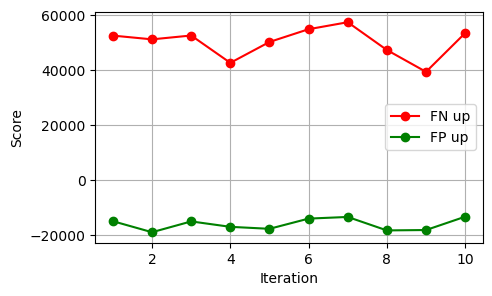

Average custom score with increased FN:  50144.136
Average custom score with increased FP:  -15981.997


In [89]:
calculate_sensitivity(baseline_df)

In the results of the cross-validation we can see that the model quality based on the custom model evaluation is more sensitive to false positive values than to false negative values. We can see this in the graph because the score for an increase in FP values decreases more than for an increase in FN values compared to the baseline model.

This means, if we falsely predict that one should buy a ticket now, but the price will actually go down, it is worse than if we falsely predict that one should wait, but the price will actually go up. To look at the proportion of FPs, the score 'Precision' is best suited. A high precision indicates that there are few FPs. Theoretically, we could simply try to maximise this score. However, we would then ignore the fact that while it is important to avoid FPs, it is still important to have a high enough rate of TPs to fulfil the purpose of the model, i.e. to actually recommend purchases and not recommend users to wait all the time. 

Therefore, we will use the F1 score as the score to optimise, because it is a harmonic mean of precision and recall. This means that we can strike a balance between precision and recall while minimizing the cost of false positives. This is to avoid FPs, but it also takes into account that TPs are also predicted.

#### Define the target variable and the features ####

For the Training we will use the correct *min_future_price_in_Eur*, not the predicted ones, so we learn on the most precise data as possible and don't train on data, which containes errors.

In [90]:
features = [
    'Departure_hour', 'flight_unique_id', 'Price_In_Eur',
    'min_future_price_in_Eur', 'days_between_request_and_flight', 'flight_is_weekend',
    'is_holiday', 'route_FRA-STN', 'route_STN-FRA', 'route_STN-SXF', 'route_SXF-STN',
    'price_difference', 'month_flight', 'month_request', 'rolling_mean_price',
    'price_increase_frequency', 'num_requests'
]
target = 'buy'

# Splitting the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df_copy[features], df_copy[target], test_size=0.2, random_state=42)

#### Model Training ####

For our classification task, we have chosen to examine five distinct classifiers to provide a holistic understanding of their capabilities and performances. After an initial comparison, we'll refine and further optimize the top-performing models. This ensures we harness the best model tailored to our specific needs. We will try out the following models: <a name="geron">[1]</a> [link](#geron) TODO

*   **Logistic Regression** <br>
Logistic Regression serves as an excellent starting point due to its simplicity and rapid training capabilities. Even though it's considered a basic model, its efficiency should not be underestimated. For certain tasks, especially when the relationships between features and the target are predominantly linear, Logistic Regression can prove to be a surprisingly effective choice. Choosing this model also allows us to establish a baseline performance, from which we can evaluate the enhancements provided by more complex models.

*   **Random Forest Classifier** <br>
Random Forests enhance our model assessment by being adept at handling both linear and non-linear data types. Understanding which attributes significantly impact the predictions becomes feasible with their feature importance capabilities. The ensemble nature of Random Forests, employing numerous decision trees, inherently provides protection against overfitting, marking them as a versatile choice for various classification problems.

*   **Gradient Boosting Classifier** <br>
Gradient Boosting is renowned for its superiority in binary classification contexts. It's notably effective when dealing with imbalanced datasets and can model complex relationships. It's essential to be aware that to unlock its full potential, dedicated time might be required for hyperparameter tuning.

*   **XGBoost Classifier** <br>
XGBoost distinguishes itself with a blend of remarkable predictive accuracy paired with computational efficiency. Tailored for handling imbalanced datasets, it comes with built-in regularization, reducing overfitting risks. Its flexibility in defining custom optimization objectives and wide tunability renders it a prime choice for an array of classification tasks.

*   **MLP Classifier** <br>
MLP Classifier is a neural network-based model that can handle non-linear data. It's a powerful model that can be used for a variety of classification tasks. However, it's prone to overfitting, and its training can be computationally expensive. Nevertheless, it's a valuable addition to our model selection, providing a different perspective on the data.

*   **AdaBoost Classifier** <br>
AdaBoost is an ensemble method that combines multiple weak learners to create a strong learner. It's a versatile model that can be used for both classification and regression tasks. It's also relatively fast to train and can handle non-linear data. However, it's prone to overfitting, and its performance can be sensitive to noisy data.

Our rationale for these classifier selections is to encapsulate a diverse range of techniques. From the foundational nature of logistic regression to the advanced adaptability of ensemble methods, our objective is to ensure that the finalized model provides the optimal performance for our dataset.

In [91]:
# Ensure all non-numeric columns are properly encoded or dropped
X_train = X_train.select_dtypes(include=[np.number])

# Train a Logistic Regression Classifier
lr = LogisticRegression(random_state=42)
lr.fit(X_train, y_train)

# Train a RandomForest classifier
rfc = RandomForestClassifier(n_estimators=100, random_state=42)
rfc.fit(X_train, y_train)

# Train a XGBoost Classifier
xgb = XGBClassifier(random_state=42)
xgb.fit(X_train, y_train)

# Train a GradientBoosting Classifier
gbc = GradientBoostingClassifier(random_state=42)
gbc.fit(X_train, y_train)

# Train a MLP Classifier
mlp = MLPClassifier(random_state=42)
mlp.fit(X_train, y_train)

# Train a AdaBoost Classifier
abc = AdaBoostClassifier(random_state=42)
abc.fit(X_train, y_train)

AdaBoostClassifier(random_state=42)

##### Model Comparison #####

In [92]:
scoring = {'acc': 'accuracy', 'prec': 'precision', 'rec': 'recall', 'f1': 'f1', 'roc': 'roc_auc'}

# make predictions and calculate evaluation scores
lr_pred = lr.predict(X_test)
lr_scores = calculate_metrics(y_test, lr_pred)
lr_cross_val_scores = cross_validate(lr, X_train, y_train, scoring=scoring, cv=5)
custom_score_lr = custom_score(X_test, df_copy, lr_pred)

rfc_pred = rfc.predict(X_test)
rfc_scores = calculate_metrics(y_test, rfc_pred)
rfc_cross_val_scores = cross_validate(rfc, X_train, y_train, scoring=scoring, cv=5)
custom_score_rfc = custom_score(X_test, df_copy, rfc_pred)

xgb_pred = xgb.predict(X_test)
xgb_scores = calculate_metrics(y_test, xgb_pred)
xgb_cross_val_scores = cross_validate(xgb, X_train, y_train, scoring=scoring, cv=5)
custom_score_xgb = custom_score(X_test, df_copy, xgb_pred)

gbc_pred = gbc.predict(X_test)
gbc_scores = calculate_metrics(y_test, gbc_pred)
gbc_cross_val_scores = cross_validate(gbc, X_train, y_train, scoring=scoring, cv=5)
custom_score_gbc = custom_score(X_test, df_copy, gbc_pred)

mlp_pred = mlp.predict(X_test)
mlp_scores = calculate_metrics(y_test, mlp_pred)
mlp_cross_val_scores = cross_validate(mlp, X_train, y_train, scoring=scoring, cv=5)
custom_score_mlp = custom_score(X_test, df_copy, mlp_pred)

abc_pred = abc.predict(X_test)
abc_scores = calculate_metrics(y_test, abc_pred)
abc_cross_val_scores = cross_validate(abc, X_train, y_train, scoring=scoring, cv=5)
custom_score_abc = custom_score(X_test, df_copy, abc_pred)

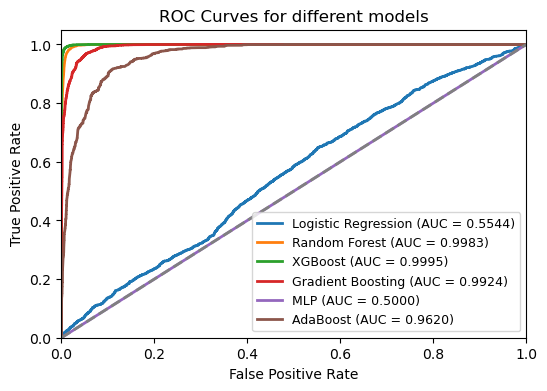

In [93]:
models = [lr, rfc, xgb, gbc, mlp, abc]
model_names = ['Logistic Regression', 'Random Forest', 'XGBoost', 'Gradient Boosting', 'MLP', 'AdaBoost']
plot_roc_curves(models, X_test, y_test, model_names)

From the ROC curves, some differences between the models can be observed. The ROC AUC score of the MLPClassifier is 0.5, which means that the classifier is no better than random guessing. Logistic Regression has a ROC AUC score of 0.55, so it's also not much better than random guessing. The Random Forest Classifier, XGBoost, and Gradient Boosting have nearly perfect ROC curves, and AdaBoost also has a quite high ROC AUC score of 0.96. This means that the last 4 models are potentially well-suited to classify the data. However, the ROC AUC score alone is not indicative enough to decide which model is the best. Therefore, we will further investigate the models.

In [94]:
# Make a clear table to compare the scores for the 5 models
table_test = PrettyTable()

# Add columns
table_test.field_names = ["Model", "Accuracy", "Precision", "Recall", "F1", "ROC AUC", "Custom Score"]

# Add rows
table_test.add_row(["LogisticRegression", lr_scores['acc'], lr_scores['prec'], lr_scores['rec'], lr_scores['f1'], lr_scores['roc'], custom_score_lr])
table_test.add_row(["RandomForestClassifier", rfc_scores['acc'], rfc_scores['prec'], rfc_scores['rec'],  rfc_scores['f1'], rfc_scores['roc'], custom_score_rfc])
table_test.add_row(["XGBClassifier", xgb_scores['acc'], xgb_scores['prec'], xgb_scores['rec'], xgb_scores['f1'], xgb_scores['roc'], custom_score_xgb])
table_test.add_row(["GradientBoostingClassifier", gbc_scores['acc'], gbc_scores['prec'], gbc_scores['rec'], gbc_scores['f1'], gbc_scores['roc'], custom_score_gbc])
table_test.add_row(["MLPClassifier", mlp_scores['acc'], mlp_scores['prec'], mlp_scores['rec'], mlp_scores['f1'], mlp_scores['roc'], custom_score_mlp])
table_test.add_row(["AdaBoostClassifier", abc_scores['acc'], abc_scores['prec'], abc_scores['rec'], abc_scores['f1'], abc_scores['roc'], custom_score_abc])

print('Test Set Scores:')
table_test

Test Set Scores:


Model,Accuracy,Precision,Recall,F1,ROC AUC,Custom Score
LogisticRegression,0.7744095665171898,0.0,0.0,0.0,0.5,67890.5692
RandomForestClassifier,0.9826606875934231,0.9725915875169606,0.9499072356215214,0.9611155805846071,0.9710546060751215,15331.81
XGBClassifier,0.9919282511210762,0.9802006335797254,0.9840975351179433,0.9821452188863907,0.989153461814685,30109.9
GradientBoostingClassifier,0.9524663677130045,0.9550733496332519,0.8282533792737874,0.8871540099361248,0.9084518903780919,-30418.99
MLPClassifier,0.7744095665171898,0.0,0.0,0.0,0.5,67890.5692
AdaBoostClassifier,0.8938116591928251,0.8963874553394204,0.5984627617280679,0.7177368086458995,0.7891557168739166,-135934.84


Logistic Regression and MLPClassifier have very poor values for Precision, Recall, and F1-Score. This is also evident in the subsequent confusion matrices, as these models only predict False, i.e., not to buy. Therefore, we will no longer consider these two models, even if the Custom Score for these models is very good. But if we only predict False, the Custom Score is also good because we then rarely have to pay a high price, but for instance, customers are never recommended that they should buy now. This, of course, misses the point.

The RandomForestClassifier, XGBClassifier, and GradientBoostingClassifier have very good values for Accuracy and Precision. The GradientBoostingClassifier, however, has slightly worse values for Recall and F1-Score compared to the other two models. The AdaBoostClassifier has relatively high values for Accuracy and Precision, but the Recall and the F1-Score are very poor compared to the others. Considering the Custom Score, the AdaBoostClassifier is by far the worst, but the GradientBoostingClassifier also does not produce good results here. This aligns with the results from the Sensitivity Analysis, where we found that False Positives, in particular, have a significant impact and can worsen the Custom Score. To change this, the F1-Score and Recall would need to be improved.

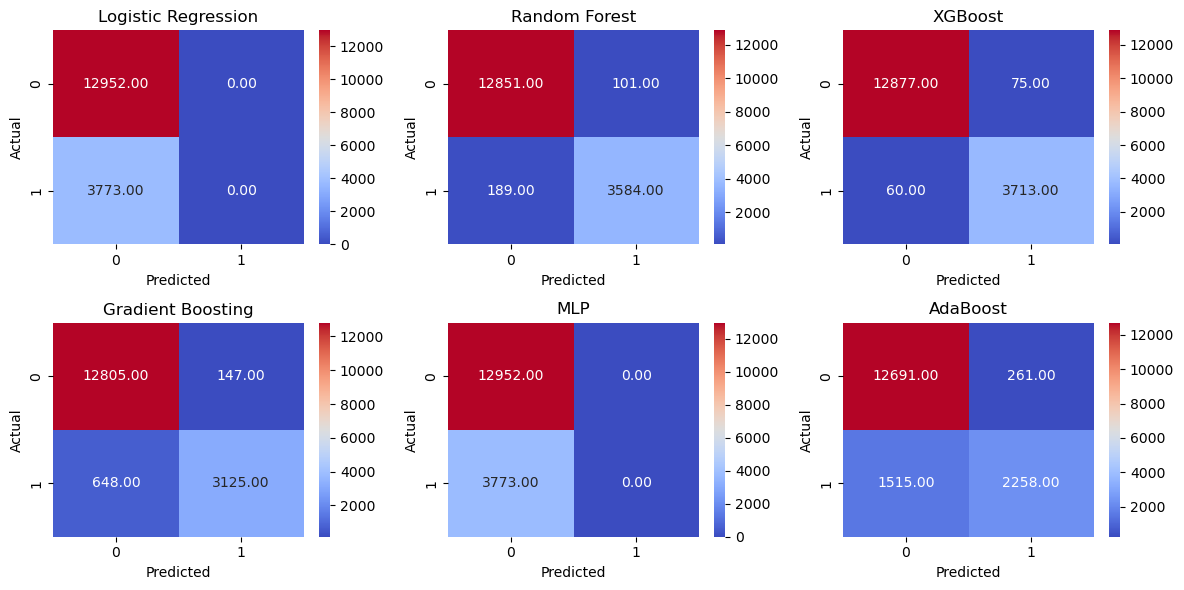

In [95]:
y_preds = [lr_pred, rfc_pred, xgb_pred, gbc_pred, mlp_pred, abc_pred]
model_names = ['Logistic Regression', 'Random Forest', 'XGBoost', 'Gradient Boosting', 'MLP', 'AdaBoost']
plot_confusion_matrices(y_test, y_preds, model_names)

The confusion matrices clearly show that Logistic Regression and MLPClassifier only predict False. Gradient Boosting and AdaBoost have a large number of False Negatives and also relatively many False Positives compared to Random Forest and XGBoost. Compared to the other models, Random Forest and XGBoost have relatively few False Positives and False Negatives, with XGBoost having slightly better values than Random Forest.

In [96]:
# Make a clear table to compare the cv scores for the 5 models
table_cv = PrettyTable()

# Add columns
table_cv.field_names = ["Model", "Accuracy", "Precision", "Recall", "F1", "ROC AUC", "Custom Score"]

# Add rows
table_cv.add_row(["LogisticRegression", lr_cross_val_scores['test_acc'].mean(), lr_cross_val_scores['test_prec'].mean(), lr_cross_val_scores['test_rec'].mean(), lr_cross_val_scores['test_f1'].mean(), lr_cross_val_scores['test_roc'].mean(), custom_score_lr])
table_cv.add_row(["RandomForestClassifier", rfc_cross_val_scores['test_acc'].mean(), rfc_cross_val_scores['test_prec'].mean(), rfc_cross_val_scores['test_rec'].mean(),  rfc_cross_val_scores['test_f1'].mean(), rfc_cross_val_scores['test_roc'].mean(), custom_score_rfc])
table_cv.add_row(["XGBClassifier", xgb_cross_val_scores['test_acc'].mean(), xgb_cross_val_scores['test_prec'].mean(), xgb_cross_val_scores['test_rec'].mean(), xgb_cross_val_scores['test_f1'].mean(), xgb_cross_val_scores['test_roc'].mean(), custom_score_xgb])
table_cv.add_row(["GradientBoostingClassifier", gbc_cross_val_scores['test_acc'].mean(), gbc_cross_val_scores['test_prec'].mean(), gbc_cross_val_scores['test_rec'].mean(), gbc_cross_val_scores['test_f1'].mean(), gbc_cross_val_scores['test_roc'].mean(), custom_score_gbc])
table_cv.add_row(["MLPClassifier", mlp_cross_val_scores['test_acc'].mean(), mlp_cross_val_scores['test_prec'].mean(), mlp_cross_val_scores['test_rec'].mean(), mlp_cross_val_scores['test_f1'].mean(), mlp_cross_val_scores['test_roc'].mean(), custom_score_mlp])
table_cv.add_row(["AdaBoostClassifier", abc_cross_val_scores['test_acc'].mean(), abc_cross_val_scores['test_prec'].mean(), abc_cross_val_scores['test_rec'].mean(), abc_cross_val_scores['test_f1'].mean(), abc_cross_val_scores['test_roc'].mean(), custom_score_abc])

print('Cross-Validation Scores:')
table_cv

Cross-Validation Scores:


Model,Accuracy,Precision,Recall,F1,ROC AUC,Custom Score
LogisticRegression,0.776603536475017,0.0,0.0,0.0,0.5630903736497644,67890.5692
RandomForestClassifier,0.9786992666708452,0.9661696717122643,0.9375041820006691,0.95161057783851,0.9974327134949681,15331.81
XGBClassifier,0.9903586147936589,0.9771133737372757,0.9797925727668115,0.978450089514164,0.9993664697236749,30109.9
GradientBoostingClassifier,0.9548723000405227,0.9538044936580456,0.8386082301773168,0.8925020384490221,0.9922166873942266,-30418.99
MLPClassifier,0.776603536475017,0.0,0.0,0.0,0.5,67890.5692
AdaBoostClassifier,0.8914184612768533,0.8824214808079027,0.5933087989294078,0.7092163300742345,0.9601574772333011,-135934.84


To double-check and ensure that the model doesn't just happen to work well for the test set by chance, we calculated the Cross-Validation scores for the training set. It is important to note that these scores might potentially be higher than in reality since we train the model on the training set and then test it on the same training set. However, in combination with the examination of the scores for the test set, we can still make a statement about the quality of the model. The scores are very similar to the scores for the test set, which means the model works well not only by chance for the test set but also for the training set. This indicates that the model generalizes well and is not overfitted.

##### Conclusion #####



Logistic Regression and the MLPClassifier seem the least promising, as they currently always predict False. We will optimize the other four models, as they all have more or less good scores, and we want to explore as many options as possible to find the best model.

#### Model Tuning ####

Similar to the regression, we will also use a Bayesian optimizer here to optimize the hyperparameters of all selected models.

##### 1. RandomForestClassifier #####

In [97]:
# Define the function to optimize
def optimize(n_estimators, max_depth, min_samples_split, min_samples_leaf):
    rfc = RandomForestClassifier(n_estimators=int(n_estimators),
                                  max_depth=int(max_depth),
                                  min_samples_split=int(min_samples_split),
                                  min_samples_leaf=int(min_samples_leaf),
                                  random_state=42)
    
    rfc.fit(X_train, y_train)

    rfc_pred = rfc.predict(X_test)
    return f1_score(y_test, rfc_pred)

In [98]:
# Initialize the optimizer
optimizer = BayesianOptimization(f=optimize, pbounds={
    'n_estimators': (10, 1000),
    'max_depth': (3, 50),
    'min_samples_split': (2, 50),
    'min_samples_leaf': (1, 50)
})

# Perform the optimization
optimizer.maximize(n_iter=25, init_points=10)

|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------


| 1         | 0.7961    | 12.32     | 10.3      | 31.67     | 362.7     |
| 2         | 0.9006    | 21.46     | 14.03     | 29.27     | 808.1     |
| 3         | 0.9068    | 32.58     | 10.64     | 36.91     | 666.6     |
| 4         | 0.9189    | 25.78     | 10.17     | 14.91     | 636.6     |
| 5         | 0.8286    | 43.28     | 35.0      | 26.74     | 114.3     |
| 6         | 0.01994   | 3.908     | 24.84     | 23.16     | 774.6     |
| 7         | 0.8883    | 48.46     | 17.61     | 5.355     | 315.6     |
| 8         | 0.8598    | 36.3      | 23.08     | 2.048     | 70.11     |
| 9         | 0.8588    | 14.42     | 14.3      | 16.84     | 338.6     |
| 10        | 0.81      | 14.58     | 30.66     | 39.82     | 893.4     |
| 11        | 0.8622    | 37.35     | 24.04     | 3.12      | 69.83     |
| 12        | 0.9192    | 35.01     | 5.813     | 34.22     | 835.3     |
| 13        | 0.8366    | 50.0      | 33.02     | 49.41     | 820.3     |
| 14        | 0.9628    | 48.33     | 

As with the Random Forest Regressor, we found out it's very difficult to optimize the hyperparameters. We tested various intervals and also different hyperparameter tuning options like RandomizedSearchCV and GridSearchCV but couldn't find good parameters that didn't lie on the edges of the interval and improve the score. Nevertheless, we will train the model with the best parameters in order to compare it with the other models after optimizing all of them.

In [99]:
# retrains the model with the best parameters
rfc_best_params = optimizer.max['params']

rfc_best_params['n_estimators'] = int(round(rfc_best_params['n_estimators']))
rfc_best_params['max_depth'] = int(round(rfc_best_params['max_depth']))
rfc_best_params['min_samples_split'] = int(round(rfc_best_params['min_samples_split']))
rfc_best_params['min_samples_leaf'] = int(round(rfc_best_params['min_samples_leaf']))

rfc_best = RandomForestClassifier(random_state=42, **rfc_best_params)
# rfc_best = RandomForestClassifier(random_state=42, n_estimators=296, max_depth=50, min_samples_split=8, min_samples_leaf=1)
rfc_best.fit(X_train, y_train)

rfc_optimized_scores_cv = cross_validate(rfc_best, X_train, y_train, scoring=scoring, cv=5)

rfc_optimized_pred = rfc.predict(X_test)
rfc_optimized_scores = calculate_metrics(y_test, rfc_optimized_pred)
custom_score_rfc_optimized = custom_score(X_test, df_copy, rfc_optimized_pred)

In [100]:
# check the scores
table = PrettyTable()
table.field_names = ['Data', 'Accuracy', 'Precision', 'Recall', 'F1', 'ROC AUC', 'Custom Score']

table.add_row(["CV before optimization", rfc_cross_val_scores['test_acc'].mean(), rfc_cross_val_scores['test_prec'].mean(), rfc_cross_val_scores['test_rec'].mean(),  rfc_cross_val_scores['test_f1'].mean(), rfc_cross_val_scores['test_roc'].mean(), '---'])
table.add_row(['CV', rfc_optimized_scores_cv['test_acc'].mean(), rfc_optimized_scores_cv['test_prec'].mean(), rfc_optimized_scores_cv['test_rec'].mean(), rfc_optimized_scores_cv['test_f1'].mean(), rfc_optimized_scores_cv['test_roc'].mean(), '---'])
table.add_row(['Test set before optimization', rfc_scores['acc'], rfc_scores['prec'], rfc_scores['rec'], rfc_scores['f1'], rfc_scores['roc'], custom_score_rfc])
table.add_row(['Test set', rfc_optimized_scores['acc'], rfc_optimized_scores['prec'], rfc_optimized_scores['rec'], rfc_optimized_scores['f1'], rfc_optimized_scores['roc'], custom_score_rfc_optimized])

table

Data,Accuracy,Precision,Recall,F1,ROC AUC,Custom Score
CV before optimization,0.9786992666708452,0.9661696717122643,0.9375041820006691,0.95161057783851,0.9974327134949681,---
CV,0.9790281112302471,0.9655850289149303,0.9396453663432587,0.9524241199289543,0.9976480261995718,---
Test set before optimization,0.9826606875934231,0.9725915875169606,0.9499072356215214,0.9611155805846071,0.9710546060751215,15331.81
Test set,0.9826606875934231,0.9725915875169606,0.9499072356215214,0.9611155805846071,0.9710546060751215,15331.81


The table shows that the model performs strongly in cross-validation and in the test data set. This can be seen in the high scores for accuracy, precision, recall, roc auc and F1-score which are quite similar for the CV and the test set. The scores are slighly better for the test set. This could mean that the model is not overfitting the data but this could be also due to the smaller size of the test set.

But we can also see that the the scores didn't improve compared to the default parameters. Just the Recall score improved a little bit for the CV scores. The scores for the test set are exactely the same as for the default parameters.

The comparable performance between CV and test dataset suggests that the model has some consistency in its predictions, but we will see how well this model performs compared to the other models later on.


##### 2. XGBClassifier #####

In [101]:
# Define the function to optimize
def optimize(n_estimators, max_depth, learning_rate, min_child_weight, gamma, subsample, colsample_bytree):
    xgb = XGBClassifier(n_estimators=int(n_estimators),
                        max_depth=int(max_depth),
                        learning_rate=learning_rate,
                        min_child_weight=int(min_child_weight),
                        gamma=gamma,
                        subsample=subsample,
                        colsample_bytree=colsample_bytree,
                        random_state=42)
    
    xgb.fit(X_train, y_train)

    xgb_pred = xgb.predict(X_test)
    return f1_score(y_test, xgb_pred)

In [102]:
# Initialize the optimizer
optimizer = BayesianOptimization(f=optimize, pbounds={
    'colsample_bytree': (0.8, 1),
    'gamma': (0, 0.5),
    'learning_rate': (0.01, 0.5),
    'max_depth': (3, 50),
    'min_child_weight': (1, 10),
    'n_estimators': (10, 1000),
    'subsample': (0.8, 1)
})

# Perform the optimization
optimizer.maximize(n_iter=20, init_points=10)

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------------------


| 1         | 0.9658    | 0.9123    | 0.2063    | 0.3004    | 3.591     | 7.654     | 208.9     | 0.9659    |
| 2         | 0.9878    | 0.8417    | 0.3622    | 0.4305    | 26.34     | 1.113     | 790.8     | 0.8781    |
| 3         | 0.9861    | 0.8002    | 0.06242   | 0.4007    | 37.34     | 9.698     | 716.2     | 0.9453    |
| 4         | 0.9891    | 0.8485    | 0.251     | 0.0737    | 32.91     | 1.722     | 143.8     | 0.9633    |
| 5         | 0.7309    | 0.8216    | 0.4374    | 0.04422   | 4.382     | 5.945     | 73.75     | 0.8059    |
| 6         | 0.9858    | 0.9744    | 0.4363    | 0.1911    | 48.21     | 6.012     | 226.2     | 0.9341    |
| 7         | 0.9893    | 0.9216    | 0.05379   | 0.05116   | 44.53     | 1.402     | 629.3     | 0.8474    |
| 8         | 0.985     | 0.893     | 0.008677  | 0.2495    | 21.63     | 4.934     | 792.8     | 0.8702    |
| 9         | 0.9846    | 0.8482    | 0.282     | 0.4315    | 35.89     | 7.477     | 511.3     | 0.8695    |
| 10      

In [103]:
# Initialize the optimizer
optimizer = BayesianOptimization(f=optimize, pbounds={
    'colsample_bytree': (0.8, 0.95),
    'gamma': (0, 0.5),
    'learning_rate': (0.1, 0.45),
    'max_depth': (15, 30),
    'min_child_weight': (1, 5),
    'n_estimators': (600, 1000),
    'subsample': (0.8, 1)
})

# Perform the optimization
optimizer.maximize(n_iter=20, init_points=10)

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------------------


| 1         | 0.9869    | 0.8273    | 0.4147    | 0.3492    | 27.65     | 2.12      | 915.4     | 0.8666    |
| 2         | 0.9871    | 0.9101    | 0.1098    | 0.2895    | 24.66     | 3.822     | 901.3     | 0.9567    |
| 3         | 0.9882    | 0.8282    | 0.3621    | 0.1024    | 22.74     | 4.665     | 779.4     | 0.8505    |
| 4         | 0.9885    | 0.8152    | 0.2393    | 0.2138    | 28.83     | 1.909     | 709.0     | 0.9847    |
| 5         | 0.9877    | 0.8228    | 0.3239    | 0.2386    | 17.65     | 4.553     | 622.7     | 0.9433    |
| 6         | 0.9879    | 0.8167    | 0.3415    | 0.3354    | 27.77     | 4.739     | 845.5     | 0.8911    |
| 7         | 0.9878    | 0.9441    | 0.1477    | 0.3254    | 26.03     | 3.356     | 659.6     | 0.8624    |
| 8         | 0.9872    | 0.8782    | 0.4605    | 0.3674    | 19.3      | 3.11      | 828.6     | 0.9833    |
| 9         | 0.9889    | 0.9057    | 0.2144    | 0.1417    | 29.8      | 1.592     | 739.1     | 0.9377    |
| 10      

In [104]:
# retrains the model with the best parameters
xgb_best_params = optimizer.max['params']
# xgb_best_params = {'colsample_bytree': 0.8271, 'gamma': 0.4552, 'learning_rate': 0.04636, 'max_depth': 33.2, 'min_child_weight': 1.867, 'n_estimators': 632.5, 'subsample': 0.8797}

xgb_best_params['n_estimators'] = int(round(xgb_best_params['n_estimators']))
xgb_best_params['max_depth'] = int(round(xgb_best_params['max_depth']))
xgb_best_params['learning_rate'] = xgb_best_params['learning_rate']
xgb_best_params['min_child_weight'] = int(round(xgb_best_params['min_child_weight']))
xgb_best_params['subsample'] = max(min(xgb_best_params['subsample'], 1), 0)
xgb_best_params['colsample_bytree'] = max(min(xgb_best_params['colsample_bytree'], 1), 0)

xgb_best = XGBClassifier(random_state=42, **xgb_best_params)
xgb_best.fit(X_train, y_train)

xgb_optimized_scores_cv = cross_validate(xgb_best, X_train, y_train, scoring=scoring, cv=5)

xgb_optimized_pred = xgb_best.predict(X_test)
xgb_optimized_scores = calculate_metrics(y_test, xgb_optimized_pred)
custom_score_xgb_optimized = custom_score(X_test, df_copy, xgb_optimized_pred)

In [105]:
# check the scores
table = PrettyTable()
table.field_names = ['Data', 'Accuracy', 'Precision', 'Recall', 'F1', 'ROC AUC', 'Custom Score']

table.add_row(["CV before optimization", xgb_cross_val_scores['test_acc'].mean(), xgb_cross_val_scores['test_prec'].mean(), xgb_cross_val_scores['test_rec'].mean(),  xgb_cross_val_scores['test_f1'].mean(), xgb_cross_val_scores['test_roc'].mean(), '---'])
table.add_row(['CV', xgb_optimized_scores_cv['test_acc'].mean(), xgb_optimized_scores_cv['test_prec'].mean(), xgb_optimized_scores_cv['test_rec'].mean(), xgb_optimized_scores_cv['test_f1'].mean(), xgb_optimized_scores_cv['test_roc'].mean(), '---'])
table.add_row(['Test set before optimization', xgb_scores['acc'], xgb_scores['prec'], xgb_scores['rec'], xgb_scores['f1'], xgb_scores['roc'], custom_score_xgb])
table.add_row(['Test set', xgb_optimized_scores['acc'], xgb_optimized_scores['prec'], xgb_optimized_scores['rec'], xgb_optimized_scores['f1'], xgb_optimized_scores['roc'], custom_score_xgb_optimized])

table

Data,Accuracy,Precision,Recall,F1,ROC AUC,Custom Score
CV before optimization,0.9903586147936589,0.9771133737372757,0.9797925727668115,0.978450089514164,0.9993664697236749,---
CV,0.9926306894402366,0.9825735686818092,0.9844764135162262,0.9835210751279098,0.9996431085853874,---
Test set before optimization,0.9919282511210762,0.9802006335797254,0.9840975351179433,0.9821452188863907,0.989153461814685,30109.9
Test set,0.9952765321375187,0.9901804670912951,0.9888682745825603,0.9895239358175308,0.9930057864574321,29382.48


From the various scores, one can see that the optimization of the XGBClassifier has improved most of the scores slightly. Only the custom score has dropped slightly.
The scores determined using CV are very similar to the scores calculated for the test set, which initially suggests that the model is not overfitting.

##### 3. GradientBoostingClassifier ######

In [108]:
# Define the function to optimize
def optimize(n_estimators, max_depth, min_samples_split, min_samples_leaf):
    gbc = GradientBoostingClassifier(n_estimators=int(n_estimators),
                                  max_depth=int(max_depth),
                                  min_samples_split=int(min_samples_split),
                                  min_samples_leaf=int(min_samples_leaf),
                                  random_state=42)
    
    gbc.fit(X_train, y_train)

    gbc_pred = gbc.predict(X_test)
    return f1_score(y_test, gbc_pred)

In [111]:
# Initialize the optimizer
optimizer = BayesianOptimization(f=optimize, pbounds={
    'n_estimators': (10, 1000),
    'max_depth': (3, 50),
    'min_samples_split': (2, 50),
    'min_samples_leaf': (1, 50)
})

# Perform the optimization
optimizer.maximize(n_iter=20, init_points=10)

|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 1         | 0.989     | 10.4      | 4.641     | 31.18     | 571.5     |
| 2         | 0.9866    | 9.736     | 18.76     | 31.4      | 220.2     |
| 3         | 0.9862    | 35.01     | 37.18     | 36.06     | 456.7     |
| 4         | 0.9866    | 24.29     | 39.01     | 20.32     | 664.8     |
| 5         | 0.9878    | 11.97     | 10.22     | 44.98     | 715.9     |
| 6         | 0.9887    | 10.65     | 5.841     | 21.89     | 427.6     |
| 7         | 0.9837    | 12.38     | 28.63     | 13.91     | 97.07     |
| 8         | 0.9883    | 37.88     | 16.47     | 36.35     | 464.5     |
| 9         | 0.9623    | 45.18     | 33.34     | 41.47     | 17.07     |
| 10        | 0.9851    | 40.19     | 21.4      | 29.85     | 37.49     |
| 11        | 0.9859    | 36.76     | 37.71     | 36.88     | 457.5     |
| 12        | 0.9885    | 12.04     | 

In [112]:
# Initialize the optimizer
optimizer = BayesianOptimization(f=optimize, pbounds={
    'n_estimators': (400, 700),
    'max_depth': (15, 40),
    'min_samples_split': (15, 40),
    'min_samples_leaf': (4, 6)
})

# Perform the optimization
optimizer.maximize(n_iter=20, init_points=10)

|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 1         | 0.989     | 19.1      | 4.268     | 21.68     | 491.1     |
| 2         | 0.9891    | 25.5      | 4.786     | 39.36     | 540.8     |
| 3         | 0.9895    | 28.68     | 4.618     | 32.95     | 697.5     |
| 4         | 0.9886    | 17.56     | 5.164     | 18.19     | 417.5     |
| 5         | 0.9898    | 24.66     | 5.899     | 32.65     | 622.5     |
| 6         | 0.9891    | 28.68     | 5.552     | 29.29     | 625.8     |
| 7         | 0.9878    | 38.1      | 5.311     | 19.3      | 646.7     |
| 8         | 0.9893    | 38.58     | 4.167     | 32.83     | 401.1     |
| 9         | 0.9883    | 35.56     | 5.195     | 33.71     | 423.0     |
| 10        | 0.9886    | 37.0      | 5.336     | 22.42     | 647.2     |
| 11        | 0.9893    | 23.99     | 4.705     | 34.3      | 620.5     |
| 12        | 0.9894    | 23.38     | 

In [ ]:
# Initialize the optimizer
optimizer = BayesianOptimization(f=optimize, pbounds={
    'n_estimators': (350, 900),
    'max_depth': (20, 55),
    'min_samples_split': (20, 45),
    'min_samples_leaf': (4, 6)
})

# Perform the optimization
optimizer.maximize(n_iter=20, init_points=10)

|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 1         | 0.9883    | 26.37     | 4.078     | 23.63     | 502.0     |
| 2         | 0.9891    | 38.73     | 5.541     | 29.33     | 695.5     |
| 3         | 0.989     | 24.83     | 4.946     | 38.43     | 784.0     |
| 4         | 0.9887    | 21.1      | 5.908     | 38.21     | 874.7     |
| 5         | 0.9902    | 28.74     | 5.906     | 42.74     | 877.8     |
| 6         | 0.9883    | 28.56     | 4.674     | 26.12     | 595.8     |
| 7         | 0.9883    | 43.19     | 4.037     | 21.94     | 853.6     |
| 8         | 0.9887    | 35.32     | 4.825     | 42.18     | 570.3     |
| 9         | 0.9887    | 45.06     | 5.304     | 32.01     | 847.8     |
| 10        | 0.9879    | 30.16     | 5.792     | 21.72     | 516.9     |
| 11        | 0.9882    | 37.12     | 5.716     | 27.37     | 472.8     |
| 12        | 0.989     | 28.09     | 

In [113]:
# retrains the model with the best parameters
gbc_best_params = optimizer.max['params']
# gbc_best_params = {'max_depth': 28.74, 'min_samples_leaf': 5.906, 'min_samples_split': 42.74, 'n_estimators': 877.8}

gbc_best_params['n_estimators'] = int(round(gbc_best_params['n_estimators']))
gbc_best_params['max_depth'] = int(round(gbc_best_params['max_depth']))
gbc_best_params['min_samples_split'] = int(round(gbc_best_params['min_samples_split']))
gbc_best_params['min_samples_leaf'] = int(round(gbc_best_params['min_samples_leaf']))

gbc_best = GradientBoostingClassifier(random_state=42, **gbc_best_params)
gbc_best.fit(X_train, y_train)

gbc_optimized_scores_cv = cross_validate(gbc_best, X_train, y_train, scoring=scoring, cv=5)

gbc_optimized_pred = gbc_best.predict(X_test)
gbc_optimized_scores = calculate_metrics(y_test, gbc_optimized_pred)
custom_score_gbc_optimized = custom_score(X_test, df_copy, gbc_optimized_pred)

In [114]:
# check the scores
table = PrettyTable()
table.field_names = ['Data', 'Accuracy', 'Precision', 'Recall', 'F1', 'ROC AUC', 'Custom Score']

table.add_row(["CV before optimization", gbc_cross_val_scores['test_acc'].mean(), gbc_cross_val_scores['test_prec'].mean(), gbc_cross_val_scores['test_rec'].mean(),  gbc_cross_val_scores['test_f1'].mean(), gbc_cross_val_scores['test_roc'].mean(), '---'])
table.add_row(['CV', gbc_optimized_scores_cv['test_acc'].mean(), gbc_optimized_scores_cv['test_prec'].mean(), gbc_optimized_scores_cv['test_rec'].mean(), gbc_optimized_scores_cv['test_f1'].mean(), gbc_optimized_scores_cv['test_roc'].mean(), '---'])
table.add_row(['Test set before optimization', gbc_scores['acc'], gbc_scores['prec'], gbc_scores['rec'], gbc_scores['f1'], gbc_scores['roc'], custom_score_gbc])
table.add_row(['Test set', gbc_optimized_scores['acc'], gbc_optimized_scores['prec'], gbc_optimized_scores['rec'], gbc_optimized_scores['f1'], gbc_optimized_scores['roc'], custom_score_gbc_optimized])

table

Data,Accuracy,Precision,Recall,F1,ROC AUC,Custom Score
CV before optimization,0.9548723000405227,0.9538044936580456,0.8386082301773168,0.8925020384490221,0.9922166873942266,---
CV,0.9923317402470531,0.9820979799702201,0.9836065573770492,0.9828489848271988,0.9996031255116545,---
Test set before optimization,0.9524663677130045,0.9550733496332519,0.8282533792737874,0.8871540099361248,0.9084518903780919,-30418.99
Test set,0.9949177877428999,0.9896441848114711,0.9878081102570898,0.9887252951319804,0.9923984961415159,28810.66


The scores for the GradientBoostingClassifier have all increased compared to the default parameters. Especially the recall score and the F1 score, which were relatively poor before, are now significantly better. The custom score has also improved significantly as a result of the optimisation and is now positive.
The scores that were determined using CV are again very similar to the scores calculated for the test set in this model.

##### 4. AdaBoostClassifier #####

In [115]:
# Define the function to optimize
def optimize(n_estimators, learning_rate):
    abc = AdaBoostClassifier(n_estimators=int(n_estimators),
                                  learning_rate=learning_rate,
                                  random_state=42)
    
    abc.fit(X_train, y_train)

    abc_pred = abc.predict(X_test)
    return f1_score(y_test, abc_pred)

In [ ]:
# Initialize the optimizer
optimizer = BayesianOptimization(f=optimize, pbounds={
    'n_estimators': (10, 1000),
    'learning_rate': (0.01, 0.5)
}, random_state=42)

# Perform the optimization
optimizer.maximize(n_iter=20, init_points=10)

|   iter    |  target   | learni... | n_esti... |
-------------------------------------------------


| 1         | 0.867     | 0.1935    | 951.2     |
| 2         | 0.9       | 0.3687    | 602.7     |
| 3         | 0.1632    | 0.08645   | 164.4     |
| 4         | 0.4015    | 0.03846   | 867.5     |
| 5         | 0.8868    | 0.3045    | 711.0     |
| 6         | 0.2507    | 0.02009   | 970.2     |
| 7         | 0.7651    | 0.4179    | 220.2     |
| 8         | 0.2549    | 0.09909   | 191.6     |
| 9         | 0.7079    | 0.1591    | 529.5     |
| 10        | 0.6461    | 0.2217    | 298.3     |
| 11        | 0.9194    | 0.5       | 603.9     |
| 12        | 0.9187    | 0.3344    | 935.7     |
| 13        | 0.6733    | 0.1188    | 627.5     |
| 14        | 0.9224    | 0.4571    | 732.6     |
| 15        | 0.8853    | 0.2761    | 756.8     |
| 16        | 0.9253    | 0.4605    | 784.8     |
| 17        | 0.07332   | 0.01      | 809.6     |
| 18        | 0.07526   | 0.01199   | 686.1     |
| 19        | 0.06247   | 0.01      | 771.8     |
| 20        | 0.08972   | 0.01      | 943.1     |


In [116]:
# Initialize the optimizer
optimizer = BayesianOptimization(f=optimize, pbounds={
    'n_estimators': (650, 950),
    'learning_rate': (0.4, 0.6)
}, random_state=42)

# Perform the optimization
optimizer.maximize(n_iter=20, init_points=10)

|   iter    |  target   | learni... | n_esti... |
-------------------------------------------------
| 1         | 0.9313    | 0.4749    | 935.2     |
| 2         | 0.9327    | 0.5464    | 829.6     |
| 3         | 0.9171    | 0.4312    | 696.8     |
| 4         | 0.9281    | 0.4116    | 909.9     |
| 5         | 0.9326    | 0.5202    | 862.4     |
| 6         | 0.9273    | 0.4041    | 941.0     |
| 7         | 0.93      | 0.5665    | 713.7     |
| 8         | 0.9213    | 0.4364    | 705.0     |
| 9         | 0.9263    | 0.4608    | 807.4     |
| 10        | 0.9267    | 0.4864    | 737.4     |
| 11        | 0.9295    | 0.4882    | 840.3     |
| 12        | 0.9345    | 0.5695    | 829.5     |
| 13        | 0.9253    | 0.4242    | 829.2     |
| 14        | 0.9348    | 0.5591    | 862.2     |
| 15        | 0.9252    | 0.425     | 862.0     |
| 16        | 0.9261    | 0.4155    | 862.3     |
| 17        | 0.9324    | 0.4884    | 897.3     |
| 18        | 0.935     | 0.5849    | 862.3     |


In [117]:
# retrains the model with the best parameters
abc_best_params = optimizer.max['params']
# abc_best_params = {'learning_rate': 0.5, 'n_estimators': 931.7}

abc_best_params['n_estimators'] = int(round(abc_best_params['n_estimators']))
abc_best_params['learning_rate'] = abc_best_params['learning_rate']

abc_best = AdaBoostClassifier(random_state=42, **abc_best_params)
abc_best.fit(X_train, y_train)

abc_optimized_scores_cv = cross_validate(abc_best, X_train, y_train, scoring=scoring, cv=5)

abc_optimized_pred = abc_best.predict(X_test)
abc_optimized_scores = calculate_metrics(y_test, abc_optimized_pred)
custom_score_abc_optimized = custom_score(X_test, df_copy, abc_optimized_pred)

In [118]:
# check the scores
table = PrettyTable()
table.field_names = ['Data', 'Accuracy', 'Precision', 'Recall', 'F1', 'ROC AUC', 'Custom Score']

table.add_row(["CV before optimization", abc_cross_val_scores['test_acc'].mean(), abc_cross_val_scores['test_prec'].mean(), abc_cross_val_scores['test_rec'].mean(),  abc_cross_val_scores['test_f1'].mean(), abc_cross_val_scores['test_roc'].mean(), '---'])
table.add_row(['CV', abc_optimized_scores_cv['test_acc'].mean(), abc_optimized_scores_cv['test_prec'].mean(), abc_optimized_scores_cv['test_rec'].mean(), abc_optimized_scores_cv['test_f1'].mean(), abc_optimized_scores_cv['test_roc'].mean(), '---'])
table.add_row(['Test set before optimization', abc_scores['acc'], abc_scores['prec'], abc_scores['rec'], abc_scores['f1'], abc_scores['roc'], custom_score_abc])
table.add_row(['Test set', abc_optimized_scores['acc'], abc_optimized_scores['prec'], abc_optimized_scores['rec'], abc_optimized_scores['f1'], abc_optimized_scores['roc'], custom_score_abc_optimized])

table

Data,Accuracy,Precision,Recall,F1,ROC AUC,Custom Score
CV before optimization,0.8914184612768533,0.8824214808079027,0.5933087989294078,0.7092163300742345,0.9601574772333011,---
CV,0.9708366848029802,0.9525112772052544,0.9150886584141853,0.9334022802513946,0.9961682053098407,---
Test set before optimization,0.8938116591928251,0.8963874553394204,0.5984627617280679,0.7177368086458995,0.7891557168739166,-135934.84
Test set,0.9718385650224215,0.9568345323741008,0.9165120593692022,0.9362393393799919,0.952233793736485,437.8


The scores for the AdaBoostClassifier have all increased compared to the default parameters. Especially the recall and F1 scores, which were relatively poor before, are now much better. The custom score has also improved considerably as a result of the optimisation and is now slightly positive. As in the 3 previously optimised models, the scores for the test set are similar to the scores determined using CV.

#### Model Comparison after Hyperparameter Tuning ####

Now that we have optimised all four models and looked at them individually, we want to make a final comparison of how the classifiers perform after optimisation, so that we can decide which model we want to use for the prediction.

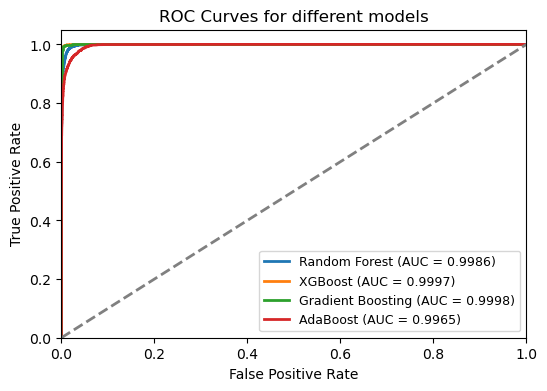

In [123]:
# plot the roc curves
models = [rfc_best, xgb_best, gbc_best, abc_best]
model_names = ['Random Forest', 'XGBoost', 'Gradient Boosting', 'AdaBoost']
plot_roc_curves(models, X_test, y_test, model_names)

The ROC curves are very similar and almost perfect for all models. This means that the models perform very well and the True Positive Rate and False Positive Rate are very good. AdaBoost has a slightly worse ROC curve than the other models, but it is still very good. But the ROC curve alone is not enough to decide which model is the best. Therefore, we will look at the other scores.

In [124]:
# print the mean of the scores in a table
table_optimized_scores = PrettyTable()
table_optimized_scores.field_names = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1', 'ROC AUC', 'Custom Score']

table_optimized_scores.add_row(['Random Forest Classifier', round(rfc_optimized_scores['acc'], 4), round(rfc_optimized_scores['prec'], 4), round(rfc_optimized_scores['rec'], 4), round(rfc_optimized_scores['f1'], 4), round(rfc_optimized_scores['roc'], 4), custom_score_rfc_optimized])
table_optimized_scores.add_row(['XGB Classifier', round(xgb_optimized_scores['acc'], 4), round(xgb_optimized_scores['prec'], 4), round(xgb_optimized_scores['rec'], 4), round(xgb_optimized_scores['f1'], 4), round(xgb_optimized_scores['roc'], 4), custom_score_xgb_optimized])
table_optimized_scores.add_row(['Gradient Boosting Classifier', round(gbc_optimized_scores['acc'], 4), round(gbc_optimized_scores['prec'], 4), round(gbc_optimized_scores['rec'], 4), round(gbc_optimized_scores['f1'], 4), round(gbc_optimized_scores['roc'], 4), custom_score_gbc_optimized])
table_optimized_scores.add_row(['AdaBoost Classifier', round(abc_optimized_scores['acc'], 4), round(abc_optimized_scores['prec'], 4), round(abc_optimized_scores['rec'], 4), round(abc_optimized_scores['f1'], 4), round(abc_optimized_scores['roc'], 4), custom_score_abc_optimized])

print('Test Set Scores:')
table_optimized_scores

Test Set Scores:


Model,Accuracy,Precision,Recall,F1,ROC AUC,Custom Score
Random Forest Classifier,0.9827,0.9726,0.9499,0.9611,0.9711,15331.81
XGB Classifier,0.9953,0.9902,0.9889,0.9895,0.993,29382.48
Gradient Boosting Classifier,0.9949,0.9896,0.9878,0.9887,0.9924,28810.66
AdaBoost Classifier,0.9718,0.9568,0.9165,0.9362,0.9522,437.8


All scores are above 0.9. XGBoost has the highest values for all scores, closely followed by GradientBoosting. The models appear to perform roughly equally well on the test data. Next is the RandomForestClassifier, which scores slightly lower in all metrics compared to the previously mentioned two. AdaBoost has the lowest scores, which is especially evident in the Custom Score.

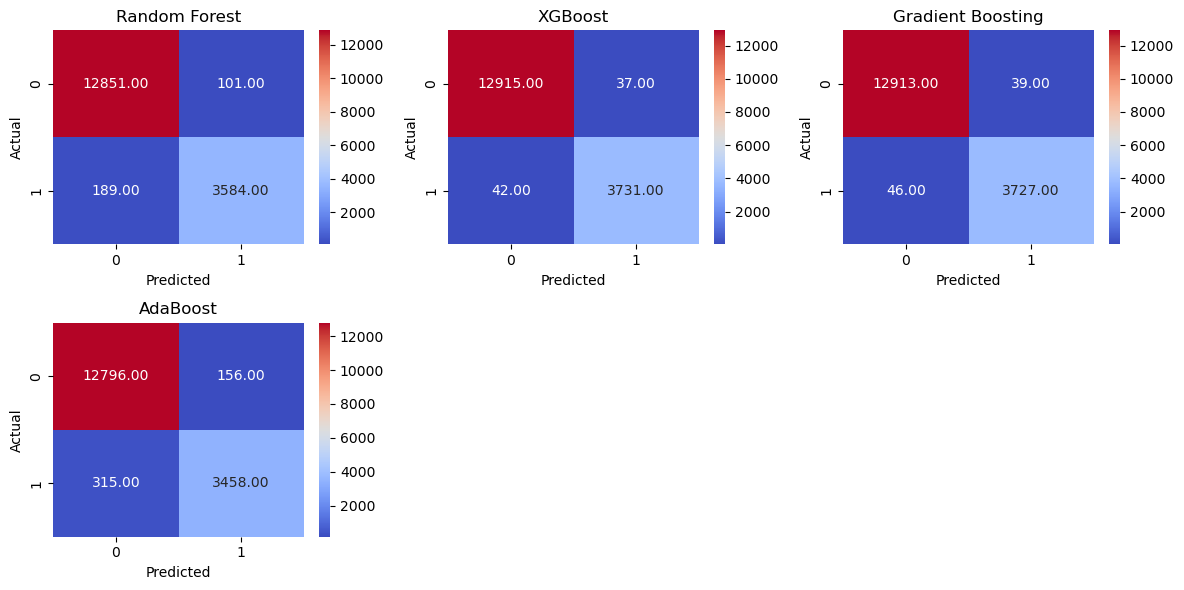

In [121]:
y_preds = [rfc_optimized_pred, xgb_optimized_pred, gbc_optimized_pred, abc_optimized_pred]
model_names = ['Random Forest', 'XGBoost', 'Gradient Boosting', 'AdaBoost']
plot_confusion_matrices(y_test, y_preds, model_names)

In the confusion matrices it can be seen that AdaBoost has the most false positives and false negatives, but has become significantly better through optimisation. Random Forest has the second most false positives and false negatives and has not improved through optimisation and has thus been overtaken by XGBoost and GradientBoosting. The number of false positives and false negatives for GradientBoosting has decreased significantly and now has the second fewest false positives and false negatives. Only XGBoost is a little better and has now the fewest FPs and FNs.

In [125]:
# print the mean of the cv scores in a table
table_optimized_scores_cv = PrettyTable()
table_optimized_scores_cv.field_names = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1', 'ROC AUC']

table_optimized_scores_cv.add_row(['Random Forest Classifier', round(rfc_optimized_scores_cv['test_acc'].mean(), 4), round(rfc_optimized_scores_cv['test_prec'].mean(), 4), round(rfc_optimized_scores_cv['test_rec'].mean(), 4), round(rfc_optimized_scores_cv['test_f1'].mean(), 4), round(rfc_optimized_scores_cv['test_roc'].mean(), 4)])
table_optimized_scores_cv.add_row(['XGB Classifier', round(xgb_optimized_scores_cv['test_acc'].mean(), 4), round(xgb_optimized_scores_cv['test_prec'].mean(), 4), round(xgb_optimized_scores_cv['test_rec'].mean(), 4), round(xgb_optimized_scores_cv['test_f1'].mean(), 4), round(xgb_optimized_scores_cv['test_roc'].mean(), 4)])
table_optimized_scores_cv.add_row(['Gradient Boosting Classifier', round(gbc_optimized_scores_cv['test_acc'].mean(), 4), round(gbc_optimized_scores_cv['test_prec'].mean(), 4), round(gbc_optimized_scores_cv['test_rec'].mean(), 4), round(gbc_optimized_scores_cv['test_f1'].mean(), 4), round(gbc_optimized_scores_cv['test_roc'].mean(), 4)])
table_optimized_scores_cv.add_row(['AdaBoost Classifier', round(abc_optimized_scores_cv['test_acc'].mean(), 4), round(abc_optimized_scores_cv['test_prec'].mean(), 4), round(abc_optimized_scores_cv['test_rec'].mean(), 4), round(abc_optimized_scores_cv['test_f1'].mean(), 4), round(abc_optimized_scores_cv['test_roc'].mean(), 4)])

print('Cross-Validation Scores:')
table_optimized_scores_cv

Cross-Validation Scores:


Model,Accuracy,Precision,Recall,F1,ROC AUC
Random Forest Classifier,0.979,0.9656,0.9396,0.9524,0.9976
XGB Classifier,0.9926,0.9826,0.9845,0.9835,0.9996
Gradient Boosting Classifier,0.9923,0.9821,0.9836,0.9828,0.9996
AdaBoost Classifier,0.9708,0.9525,0.9151,0.9334,0.9962


The CV scores are very similar to the scores for the test set, which means that the models not only happen to work well for the test set, but also for the training set. Since they show the same characteristics, we will not explain them any further.

##### Conclusion #####

By comparing the models after hyperparameter tuning, it became clear that XGBoost and GradientBoosting are the best models for our task and they gave almost the same evaluation results. Even though XGBoost has slightly better scores, we decided to use the **Gradient Boosting Classifier** for the prediction, because it has improved a lot, was faster to train than XGBoost and the scores are very similar.

## Model Evaluation ##

Now we have selected 2 models that are applied in sequence to make a prediction regarding the purchase decision. First, the **Gradient Boosting Regressor** is applied to calculate the *min_future_price_in_Eur* so that this value can be used to predict *buy*. For this, the **Gradient Boosting Classifier** is applied to decide whether the customer should buy now or not.

Finally, to test again whether and how well the interaction of the two models works, we will apply them to the entire train_set.csv (i.e. training and test split) and compare the results with the true values.

We will then perform another evaluation by applying the models on the separate test dataset that we have not used before. This dataset does not include min_future_price_in_Eur and buy. Therefore, we will look at the custom score here to see how well the models perform economically.

### Evaluation on train_set.csv ###

In [139]:
X_eval_df = df_copy.drop(columns=['buy', 'min_future_price_in_Eur'])
y_eval_df = df_copy['buy']

# predict the min future prices
predicted_min_future_prices = gbr_best.predict(X_eval_df.drop(columns=['Request_Date']))
X_eval_df['min_future_price_in_Eur'] = predicted_min_future_prices

# order the columns to match the order of the columns in the training
order = list(df_copy.columns)
order.remove('buy')
X_eval_df = X_eval_df[order]

# predict buy
pred_eval_buy = gbc_best.predict(X_eval_df.drop(columns=['Request_Date']))

# calculate the scores
test_df_copy_score = custom_score(X_eval_df, df_copy, pred_eval_buy)
test_df_copy_scores = calculate_metrics(y_eval_df, pred_eval_buy)

# print the scores
table = PrettyTable()
table.field_names = ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC AUC', 'Custom Score']

table.add_row([ round(test_df_copy_scores['acc'], 4), round(test_df_copy_scores['prec'], 4), round(test_df_copy_scores['rec'], 4), round(test_df_copy_scores['f1'], 4), round(test_df_copy_scores['roc'], 4), round(test_df_copy_score, 4)])

table

Accuracy,Precision,Recall,F1,ROC AUC,Custom Score
0.9617,0.9185,0.9097,0.9141,0.9432,44895.9112


The scores for the train_set.csv are a bit smaller than the scores we have seen before in the Classification. This is probably due to the fact that the predictions of the regressor are not perfect and therefore the predictions of the classifier cannot be perfect either. However, we see that all scores are above 0.9 and the custom score is also very high.

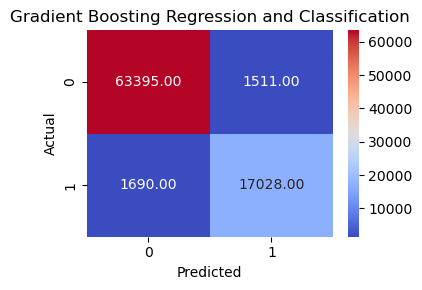

In [140]:
# plot the confusion matrix
plot_confusion_matrices(y_eval_df, [pred_eval_buy], ['Gradient Boosting Regression and Classification'])

We can clearly see from the confusion matrix that there are some false positives and false negatives. However, the amount of data is now also much larger than for the previous confusion matrices. Therefore, it is not surprising that there are more false positives and false negatives in terms of numbers. If you look at it in this relation, there are not so many and also the dark colour in the confusion matrices makes it clear that, relatively speaking, there are not so many false predictions. This also clearly shows that the recall and precision are quite high. 

Of course, the values have to be considered with caution, as we have trained the models on part of the data we are now looking at and they may therefore be somewhat higher than in reality.

### Evaluation on test_set.csv ###

In [141]:
# Create a copy of the original dataframe
test_df_copy = orig_df_test.copy()

In [142]:
# preprocess test set
test_df_copy = preprocess_dataframe(test_df_copy)

# feature engineering
test_df_copy = feature_engineering(test_df_copy)

test_df_copy.head()

,Request_Date,Departure_hour,flight_unique_id,Price_In_Eur,days_between_request_and_flight,flight_is_weekend,is_holiday,route_FRA-STN,route_STN-FRA,route_STN-SXF,route_SXF-STN,price_difference,month_flight,month_request,rolling_mean_price,price_increase_frequency,num_requests
0,2019-06-03 11:00:00,7,20190702145,3032,28,0,1,0,0,1,0,-4278.111111,7,6,3032.000000,0.0,1.0
1,2019-06-03 23:00:00,7,20190702145,4453,28,0,1,0,0,1,0,-2857.111111,7,6,3742.500000,1.0,2.0
2,2019-06-04 11:00:00,7,20190702145,4447,27,0,1,0,0,1,0,-2863.111111,7,6,3977.333333,1.0,3.0
3,2019-06-04 23:00:00,7,20190702145,4447,27,0,1,0,0,1,0,-2863.111111,7,6,4094.750000,1.0,4.0
4,2019-06-05 11:00:00,7,20190702145,4452,26,0,1,0,0,1,0,-2858.111111,7,6,4166.200000,2.0,5.0


In [144]:
# Rearrange columns to match the order of the training data
order = list(df_copy.columns)
order.remove('min_future_price_in_Eur')
order.remove('buy')
test_df_copy = test_df_copy[order]

# predict the min future prices
predicted_min_future_prices = gbr_best.predict(test_df_copy.drop(columns=['Request_Date']))
test_df_copy['min_future_price_in_Eur'] = predicted_min_future_prices

# rearrange columns to match the order of the training data
order = list(df_copy.columns)
order.remove('buy')
test_df_copy = test_df_copy[order]

# predict buy
predicted_buy = gbc_best.predict(test_df_copy.drop(columns=['Request_Date']))
test_df_copy['buy'] = predicted_buy

In [145]:
test_df_copy = test_df_copy.rename(columns={'Price_In_Eur': 'Price'})

quality_score = model_quality_evaluation(test_df_copy)

In [146]:
test_df_copy.head()

,Request_Date,Departure_hour,flight_unique_id,Price,min_future_price_in_Eur,days_between_request_and_flight,flight_is_weekend,is_holiday,route_FRA-STN,route_STN-FRA,route_STN-SXF,route_SXF-STN,price_difference,month_flight,month_request,rolling_mean_price,price_increase_frequency,num_requests,buy
0,2019-06-03 11:00:00,7,20190702145,3032,28.997605,28,0,1,0,0,1,0,-4278.111111,7,6,3032.000000,0.0,1.0,0
1,2019-06-03 23:00:00,7,20190702145,4453,35.123878,28,0,1,0,0,1,0,-2857.111111,7,6,3742.500000,1.0,2.0,0
2,2019-06-04 11:00:00,7,20190702145,4447,32.071879,27,0,1,0,0,1,0,-2863.111111,7,6,3977.333333,1.0,3.0,0
3,2019-06-04 23:00:00,7,20190702145,4447,34.962489,27,0,1,0,0,1,0,-2863.111111,7,6,4094.750000,1.0,4.0,0
4,2019-06-05 11:00:00,7,20190702145,4452,36.793606,26,0,1,0,0,1,0,-2858.111111,7,6,4166.200000,2.0,5.0,0


In [147]:
# convert the quality score to euros
quality_score_eur = quality_score / 100
print(f"Custom Score: {quality_score_eur}€")

Custom Score: 40759.7€


In [148]:
# print the average savings per request
savings_per_request = quality_score_eur / len(test_df_copy)
print(f"Average Savings per Request: {savings_per_request:.2f}€")

Average Savings per Request: 7.30€


Applying the models to the test dataset showed that users save an average of €7.89 per request.

The goal of this notebook was to develop a model that makes a purchase recommendation if it saves the customer money. We did this by analysing the data, preparing it for model training, selecting the most important features and training and optimising the models. In the process, we looked at and compared several models and then decided on the Gradient Boosting Regressor and the Gradient Boosting Classifier. With this we have a finished prediction model that can now be applied to new data to make a purchase recommendation for an flight ticket.

## Sources ##

[1] Schulferien.org (2019). School Holidays 2019 in Germany, Available at: https://www.schulferien.org/deutschland/ferien/2019/ (Accessed: 10 July 2023).

[2] World-schools.com (2019). School holidays 2019 in the UK', Available at: https://world-schools.com/de/school-holidays-in-the-uk-in-2019/ (Accessed: 10 July 2023).

[3] Spott, Prof. Dr. Martin (2023). model_quality_balance_python. Provided by Prof. Spott. (2023)

[4] Spott, Prof. Dr. Martin (2023). train_set. Provided by Prof. Spott. (2023)

[5] Spott, Prof. Dr. Martin (2023). test_set. Provided by Prof. Spott. (2023)

[6] Gruppe E. Idea to train Regressor and Classifier. (Präsentation 27.06.2023)

[7] Snoek, J., Larochelle, H., & Adams, R. P. (2012). Practical Bayesian optimization of machine learning algorithms. In Advances in neural information processing systems (pp. 2951-2959).